# Company logs  - analysis of employee efficiency in completion of tasks

# 1. About this part of the project

This file contains employee efficiency analysis part of the Company Logs prroject. It does not duplicate the files <code>model.ipynb</code> (containing regression analysis part of the project) nor <code>CompanyLogs.ipynb</code> (submitted as 'First Steps of the project' assignment) in any essential parts (except reading in the data and cleaning of data). Please note that description of the variables used and some graphs for basic exploration / description of the data are already contained in the CompanyLogs.ipynb file and are not duplicated here. 

This analysis relates to one of our two data-mining goals - to extract the developer, department and country time efficiency given a task. The purpose is to help the company to identify areas where efficiency could be improved by better planning. This would contribute to the improvement of overall efficiency of the company, thereby making it more competitive. 

Improving time efficiency could also lead to saving time in completing the tasks, which would enable to better optimize the resources. Taking on more tasks using the same resources could open an opportunity for increased growth, with the development and testing of new products, finding new customers and consolidation of present clients.

We initially defined the success criteria of this data-mining goal as follows:
- **Success criteria of analyzing developer efficiency:** We consider the analysis successful if we can identify at least two factors/patterns that have an important negative impact on task completion times and/or the efficiency of planning. </br>

This criterium could be fulfilled by just identifying the least / best performing departments / positions / countries / individual employees in terms of their efficiency of completing tasks. However, in addition it seems important that we also offer some useful recommendations, based on the analysis, on how the company could improve the task completion efficiency.

**Note:** By **efficiency**, we understand the average time it takes to complete a task (measured by the sum of WorkedMinutes by all employees involved in completing the task, or in case of measuring an individual employee's efficiency, the sum of the WorkedMinutes this employee has spent on the task). 

# 2. Loading in, cleaning and preparing the data for analysis

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime
import pickle
import time
import gzip
import datetime
import dateutil
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx #for drawing a graph 
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_pydot import write_dot
get_ipython().magic('matplotlib inline')
%matplotlib inline 
#%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot") 

In [2]:
log=pd.read_csv('StatisticsData2016NoiseFree.csv', delimiter= ',')
backup=deepcopy(log)
#log=deepcopy(backup)
log.shape

(264051, 17)

In [3]:
print(log.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264051 entries, 0 to 264050
Data columns (total 17 columns):
ID                     264051 non-null int64
ActionID               264051 non-null int64
Type                   264051 non-null object
CreateTime             264051 non-null object
SignOff                239340 non-null object
Source                 264051 non-null object
Creator                264051 non-null object
CreatorDept            263245 non-null object
ActionTimeStamp        264051 non-null object
AssignedTo             264051 non-null object
AssigneeDept           143127 non-null object
TotalMinutes           264051 non-null int64
WorkedMinutes          107522 non-null float64
EstimateInMinutes      127499 non-null float64
Category               264051 non-null int64
SubCategory            264051 non-null int64
ActivityTranslation    264051 non-null object
dtypes: float64(2), int64(5), object(10)
memory usage: 180.3 MB
None


In [3]:
float_cols = log.select_dtypes(include=['float'])

for col in float_cols.columns:
    log[col] = pd.to_numeric(log[col], downcast ='float')

As we will be analysing also the efficiency by individual employees, we will now construct a person's table, by wxtracting ingormation from the main dataframe:

In [4]:
#TABLE OF PERSONS:
#Replacing "nan" values with "-", to unable concatenation of columns:
log['Creator']=log['Creator'].fillna('-')
log['CreatorDept']=log['CreatorDept'].fillna('-')
log['AssignedTo']=log['AssignedTo'].fillna('-')
log['ActivityTranslation']=log['ActivityTranslation'].fillna('-')
log['AssigneeDept']=log['AssigneeDept'].fillna('-')

#PERSONS WHO HAVE BEEN ASSIGNING TASKS TO OTHERS:
log['tmp2']=log['Creator']+ ', '+ log['CreatorDept']    
assigners_list=list(set(list(log['tmp2']))) 
assigners_names=[]
assigner_dept=[]
for el in assigners_list:
    if type(el)==str: #'nan' value has type 'float' - must be left out
        content=el.split(', ')
        assigners_names.append(content[0])
        assigner_dept.append(content[1])
assigners=pd.DataFrame()
assigners['name']=assigners_names
assigners['dept']=assigner_dept
    
#PERSONS TO WHOME TASKS HAVE BEEN ASSIGNED:
log['tmp']=log['AssignedTo']+ ', '+ log['ActivityTranslation'] + ', '+ log['AssigneeDept']    
persons_list=list(set(list(log['tmp']))) 
names=[]
country=[]
position=[]
dept=[]
for el in persons_list:
    if type(el)==str: #'nan' value has type 'float' - must be left out
        content=el.split(', ')
        names.append(content[0])
        c=content[1].split(' ')[0]
        country.append(c)
        position.append(re.sub(c+' ', '', content[1]))
        dept.append(content[2])
persons=pd.DataFrame()
persons['name']=names
persons['country']=country
persons['dept']=dept
persons['position']=position
persons['assignee']=True

is_assigner=[]
for i, name in enumerate(names):
    if name in assigners_names:
        is_assigner.append(True)
    else:
        is_assigner.append(False)
persons['assigner']=is_assigner

#Assigners who are not assignees:
a=set(assigners_names)
b=set(names)
c=a-b
for name in c:
    idx=assigners_names.index(name)
    row=[assigners_names[idx], '-', assigner_dept[idx], '-', False, True]
    #print(row)
    tmp=pd.DataFrame([row], columns=persons.columns.values)
    persons=persons.append(tmp, ignore_index=True)
    
persons

name country         dept               position  assignee  \
0        Andrew      UK     Support1     Front Line Support      True   
1          Kaia      FR            -                  Coder      True   
2        Landyn      FR            -  Advanced Tech Support      True   
3       Richard      UK            -                  Sales      True   
4          Beau      FR            -           Test Manager      True   
5        Kieran     ITA     Support2           Tech Support      True   
6        George      FR            -  Advanced Tech Support      True   
7        Rashad      FR            -           Senior Coder      True   
8         Dulce      UK      Product        Product manager      True   
9      Brantley      FR            -                   Test      True   
10        Simon      FR  Development          Documentation      True   
11        Brady      FR     Support2  Advanced Tech Support      True   
12       Hunter      UK     Support1         Administration      True   
13      Lachlan      FR     Support2           Tech Support      True   
14     Michelle      FR  Development            Team Leader      True   
15        Quinn      FR            -  Advanced Tech Support      True   
16      Kaylynn      UK      Product        Product manager      True   
17     Brantley      FR      Testing                   Test      True   
18       Jaydon      FR            -           Senior Coder      True   
19        Dante      FR            -                  Coder      True   
20        Lyric      UK           IT            Team Leader      True   
21        Ayden      UK     Support1     Front Line Support      True   
22      Charley      FR            -            Team Leader      True   
23       Finley      UK            -                  Coder      True   
24         Liam      FR      Testing                   Test      True   
25        Caden      FR            -  Advanced Tech Support      True   
26       Steven      UK            -        Product manager      True   
27   Alessandro      UK     Support1     Front Line Support      True   
28       Kailey      UK            -                   Head      True   
29       Zaiden      FR            -  Advanced Tech Support      True   
..          ...     ...          ...                    ...       ...   
176      Callan      UK     Support1       Customer Support      True   
177     Charley      FR  Development            Team Leader      True   
178    Anabella     ITA            -           Tech Support      True   
179       Bryan      FR            -                 Intern      True   
180     Cassidy      FR  Development                  Coder      True   
181       Colby      FR      Testing                   Test      True   
182        Kaia      FR  Development                  Coder      True   
183     Beckett      FR     Support2  Advanced Tech Support      True   
184    Brittany      FR     Support2  Advanced Tech Support      True   
185       Elena      UK     Support1         Implementation      True   
186      Lailah      FR            -           Senior Coder      True   
187      Davion      FR            -           Senior Coder      True   
188    Clarissa      UK            -                 Intern      True   
189       Rosie      FR  Development           Senior Coder      True   
190       Rosie      FR            -           Senior Coder      True   
191      Ishaan      FR            -           Senior Coder      True   
192    Braelynn      FR            -                   Head      True   
193       Sadie      FR            -                   Test      True   
194   Nathaniel      FR            -            Team Leader      True   
195      Alijah      FR            -           Senior Coder      True   
196      Steven      UK      Product        Product manager      True   
197     Mikaela      UK     Support1            Team Leader      True   
198       Amare      FR     Support2  Advanced Tech Support      True

From the persons table above, we can see that some persons are missing depatment values, but some are also missing country and/or position. While most of them can be filled up with the existing values from other rows, where the person's country, department and/or position exist, there are a few cases that cannot be filled up this way. We will  fill those remaining missing values up with the value "other" (except for the person 'Customer' and 'HUB', where we will replace the missing values with just 'Customer' and 'HUB', respectively). 

After updating the persons' table, next step is to use this table to fill in the missing position and department (CreatorDept and AssigneeDept) values in our main dataframe. We can then also add there the country column and drop the current column "ActivityTranslation" which includes a concatenation of country name and assignee's position.

In [5]:
#The best way of filling up the values is to first update the persons table, so that each person appears there 
#only once, with his/her department, country and position, if these exist in any of the rows (or "-" if not). 
    
#Updating persons table:
names=list(persons["name"])
countries=list(persons["country"])
depts=list(persons["dept"])
positions=list(persons["position"])
assignees=list(persons["assignee"])
assigners=list(persons["assigner"])

#Empty dictionary:
persons2=list(set(persons["name"].unique())) #132
dict={}
for person in persons2:
    d={"country": "-", "dept": "-", "position": "-", "assignee": True, "assigner": True}
    dict[person]=d

#For unique data for persons, let's gather it to dictionary:
for i, name in enumerate(names):
    if countries[i]!="-":
        dict[name]["country"]=countries[i]
    if depts[i]!="-":
        dict[name]["dept"]=depts[i]    
    if positions[i]!="-":
        dict[name]["position"]=positions[i]
    dict[name]["assignee"]=assignees[i]
    dict[name]["assigner"]=assigners[i]

persons= pd.DataFrame.from_dict(dict).T

#Michaela seems to be a special case, because she is the only one with "HUB" as both country and position value.
#To distinguish her from others, let's also fill her dept value as "HUB":
persons["dept"]["Michaela"]="HUB"

#The person "Customer" is such a special case that it would seem useful to also fill it's country and position
#values with something different than the rest of the "other" values. Let's fill those values also with the value 
#"Customer":
persons["country"]["Customer"]="Customer"
persons["position"]["Customer"]="Customer"

#All the rest of the missing values cannot be guessed, and should be filled up with "other":
persons=persons.replace(to_replace='-', value='other')

persons

assignee  assigner country         dept               position
Adalynn        False      True   other           IT                  other
Aiden           True      True      UK     Support1       Customer Support
Alejandro       True      True      UK      Product        Product manager
Alessandro      True      True      UK     Support1     Front Line Support
Alexander       True     False      UK     Support1     Front Line Support
Alijah          True      True      FR  Development           Senior Coder
Alvaro          True      True      FR  Development           Senior Coder
Amare           True      True      FR     Support2  Advanced Tech Support
Anabella        True      True     ITA     Support2           Tech Support
Anders          True     False      UK        other           Senior Coder
Anderson        True      True      UK     Support1     Front Line Support
Andrew          True      True      UK     Support1     Front Line Support
Angeline        True      True      FR     Support2    Senior Tech Support
Angelique      False      True   other        other                  other
Anthony         True      True      FR  Development           Senior Coder
Arabella        True      True      UK     Support1     Front Line Support
Ayden           True      True      UK     Support1     Front Line Support
Azalea          True      True      FR     Support2    Senior Tech Support
Azariah         True     False      UK     Support1     Front Line Support
Beau            True      True      FR      Testing           Test Manager
Beckett         True      True      FR     Support2  Advanced Tech Support
Benson          True      True      UK     Support2    Senior Tech Support
Blaise          True      True      UK  Development                  Coder
Brady           True      True      FR     Support2  Advanced Tech Support
Braelynn        True      True      FR  Development                   Head
Brantlee        True      True      UK     Support1     Front Line Support
Brantley        True      True      FR      Testing                   Test
Brett           True      True      UK     Support2           Tech Support
Brinley         True      True     ITA      Product        Product manager
Brittany        True      True      FR     Support2  Advanced Tech Support
...              ...       ...     ...          ...                    ...
Lionel          True      True      UK      Product                  Sales
Lyric           True      True      UK           IT            Team Leader
Maisie         False      True   other        other                  other
Marcelo         True     False      UK     Support1     Front Line Support
Martha          True      True      FR     Support2             Accounting
Michaela        True      True     HUB          HUB                    HUB
Michelle        True      True      FR  Development            Team Leader
Mikaela         True      True      UK     Support1            Team Leader
Montserrat      True      True      UK     Support1     Front Line Support
Muhammad        True      True      FR     Support2  Advanced Tech Support
Nathaniel       True      True      FR        other            Team Leader
Quinn           True      True      FR     Support2  Advanced Tech Support
Rashad          True      True      FR  Development           Senior Coder
Ray             True      True      FR      Testing                   Test
Rhett           True      True     ITA        other           Tech Support
Richard         True      True      UK        other                  Sales
Rosie           True      True      FR  Development           Senior Coder
Ruben           True     False      UK     Support1     Front Line Support
Sadie           True      True      FR      Testing                   Test
Saniyah         True      True     ITA     Support2           Tech Support
Savannah       False      True   other     Support1                  other
Simon           True      True      F

Now let's fill up the missing department, country and position values also in the large dataframe. In order to do use dataFrame.replace() function for that, we need to make dictionaries for the replacement values to be used for  the respective columns. In order to apply replacing based on a dictionary (where keys are persons' names and values  are dept, position or country), we also need to replace the repsective column in the large dataframe with persons  names first, because the replace() function doesn't allow making replacements based on values in another column.

In [6]:
#Dictionaries of replacement values:
countries=persons["country"].to_dict()
depts=persons["dept"].to_dict()
positions=persons["position"].to_dict()

#Replacing values in the main dataframe:
#tmp=log[:500]
a=log["AssignedTo"]
a=a.replace(to_replace=depts)
log=log.drop(columns=["AssigneeDept"])
log["AssigneeDept"]=a

a=log["Creator"]
a=a.replace(to_replace=depts)
log=log.drop(columns=["CreatorDept"])
log["CreatorDept"]=a

a=log["AssignedTo"]
a=a.replace(to_replace=positions)
log=log.drop(columns=["ActivityTranslation"])
log["AssigneePosition"]=a

#Adding the country column:
a=log["AssignedTo"]
a=a.replace(to_replace=countries)
log["AssigneeCountry"]=a

#Dropping temporary columns:
log=log.drop(columns=["tmp2"])
log=log.drop(columns=["tmp"])


In [8]:
#Let's look at what the updated table looks like:
log.head(50)

ID  ActionID         Type        CreateTime           SignOff  \
0   111069   2221510      Problem  01/01/2014 04:51  01/01/2014 04:52   
1   111070   2221512      Problem  01/01/2014 04:51  21/01/2014 10:31   
2   111070   2222533      Problem  01/01/2014 04:51  21/01/2014 10:31   
3   111071   2221560  Enhancement  02/01/2014 01:47  06/02/2014 10:50   
4   111072   2221588      Problem  02/01/2014 11:22  06/01/2014 18:28   
5   111072   2223241      Problem  02/01/2014 11:22  06/01/2014 18:28   
6   111073   2221609      Problem  02/01/2014 12:04  12/03/2014 23:28   
7   111073   2256385      Problem  02/01/2014 12:04  12/03/2014 23:28   
8   111073   2258859      Problem  02/01/2014 12:04  12/03/2014 23:28   
9   111073   2269883      Problem  02/01/2014 12:04  12/03/2014 23:28   
10  111073   2271881      Problem  02/01/2014 12:04  12/03/2014 23:28   
11  111073   2284093      Problem  02/01/2014 12:04  12/03/2014 23:28   
12  111073   2293615      Problem  02/01/2014 12:04  12/03/2014 23:28   
13  111073   2293694      Problem  02/01/2014 12:04  12/03/2014 23:28   
14  111074   2221682      Problem  02/01/2014 15:26  08/01/2014 16:09   
15  111074   2223963      Problem  02/01/2014 15:26  08/01/2014 16:09   
16  111074   2224451      Problem  02/01/2014 15:26  08/01/2014 16:09   
17  111075   2221697      Problem  02/01/2014 15:44  15/01/2014 18:01   
18  111076   2221706      Problem  02/01/2014 15:53  30/01/2014 21:13   
19  111076   2222201      Problem  02/01/2014 15:53  30/01/2014 21:13   
20  111076   2222239      Problem  02/01/2014 15:53  30/01/2014 21:13   
21  111076   2222528      Problem  02/01/2014 15:53  30/01/2014 21:13   
22  111076   2222534      Problem  02/01/2014 15:53  30/01/2014 21:13   
23  111076   2222714      Problem  02/01/2014 15:53  30/01/2014 21:13   
24  111076   2223202      Problem  02/01/2014 15:53  30/01/2014 21:13   
25  111076   2223980      Problem  02/01/2014 15:53  30/01/2014 21:13   
26  111076   2224065      Problem  02/01/2014 15:53  30/01/2014 21:13   
27  111077   2221732  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
28  111077   2221739  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
29  111077   2324848  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
30  111077   2334159  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
31  111077   2335678  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
32  111077   2619806  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
33  111077   2634636  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
34  111077   2635244  Enhancement  02/01/2014 16:07  18/10/2014 22:06   
35  111078   2221775      Problem  02/01/2014 17:21  07/01/2014 20:09   
36  111078   2226052      Problem  02/01/2014 17:21  07/01/2014 20:09   
37  111079   2221807      Problem  02/01/2014 20:39  03/01/2014 14:50   
38  111079   2222224      Problem  02/01/2014 20:39  03/01/2014 14:50   
39  111080   2221816      Problem  02/01/2014 21:27  22/01/2014 22:02   
40  111080   2222225      Problem  02/01/2014 21:27  22/01/2014 22:02   
41  111081   2221830      Problem  02/01/2014 21:52  30/01/2014 20:28   
42  111081   2222226      Problem  02/01/2014 21:52  30/01/2014 20:28   
43  111081   2223220      Problem  02/01/2014 21:52  30/01/2014 20:28   
44  111081   2240676      Problem  02/01/2014 21:52  30/01/2014 20:28   
45  111082   2221832      Problem  02/01/2014 21:56  06/01/2014 09:52   
46  111082   2222227      Problem  02/01/2014 21:56  06/01/2014 09:52   
47  111082   2223221      Problem  02/01/2014 21:56  06/01/2014 09:52   
48  111083   2221912  Enhancement  03/01/2014 00:36  24/03/2014 16:10   
49  111083   2221920  Enhancement  03/01/2014 00:36  24/03/2014 16:10   

      Source   Creator   ActionTimeStamp AssignedTo  TotalMinutes  \
0   Customer  Customer  01/01/2014 04:51      Caden             0   
1   Customer  Customer  01/01/2014 04:51      Caden            47   
2   Customer  Customer  03/01/2014 17:54      Caden            47   
3   Inte

# 3. Analysing basic company structure and total/average worked hours by country / department / position

In this section, we will take a look at the basic company structure, as well as analyse the total and average worked minutes by country, department and position. In this analysis, we are also trying to get a better understanding of the size and impact of the issue of some departments/persons not recording their working time.

For reference: </br> 
- The analysis of efficiency (i.e. average worked minutes by task) is given in section 5. 
- Further analysis of workload over the years is provided in section 4. 
- The analysis how the number of tasks is split between Categories, SubCategories, Sourse, Type, Creator and CreatorDept, and how the actions are split between AssigneeDept and AssignedTo, is given in section 2.2 of the file <code>CompanyLogs.ipynb</code>.)

### Total worked time by individual employees

First, we will add totalWorked column to the persn's table. This would enambe to see if there are any specific departments, positions or countries that systematically do not record their working time (this column is used below).

In [7]:
worked=log.groupby(["AssignedTo"])["WorkedMinutes"].sum().to_dict()
#Add persons who are only assigners, with zero TotalWorked value:
for assigner in c:
    worked[assigner]=0

#persons["totalWorked"]=persons.index
a=pd.Series(list(persons.index))
a=a.replace(to_replace=worked)
persons["totalWorked"]=list(a)

persons

assignee  assigner country         dept               position  \
Adalynn        False      True   other           IT                  other   
Aiden           True      True      UK     Support1       Customer Support   
Alejandro       True      True      UK      Product        Product manager   
Alessandro      True      True      UK     Support1     Front Line Support   
Alexander       True     False      UK     Support1     Front Line Support   
Alijah          True      True      FR  Development           Senior Coder   
Alvaro          True      True      FR  Development           Senior Coder   
Amare           True      True      FR     Support2  Advanced Tech Support   
Anabella        True      True     ITA     Support2           Tech Support   
Anders          True     False      UK        other           Senior Coder   
Anderson        True      True      UK     Support1     Front Line Support   
Andrew          True      True      UK     Support1     Front Line Support   
Angeline        True      True      FR     Support2    Senior Tech Support   
Angelique      False      True   other        other                  other   
Anthony         True      True      FR  Development           Senior Coder   
Arabella        True      True      UK     Support1     Front Line Support   
Ayden           True      True      UK     Support1     Front Line Support   
Azalea          True      True      FR     Support2    Senior Tech Support   
Azariah         True     False      UK     Support1     Front Line Support   
Beau            True      True      FR      Testing           Test Manager   
Beckett         True      True      FR     Support2  Advanced Tech Support   
Benson          True      True      UK     Support2    Senior Tech Support   
Blaise          True      True      UK  Development                  Coder   
Brady           True      True      FR     Support2  Advanced Tech Support   
Braelynn        True      True      FR  Development                   Head   
Brantlee        True      True      UK     Support1     Front Line Support   
Brantley        True      True      FR      Testing                   Test   
Brett           True      True      UK     Support2           Tech Support   
Brinley         True      True     ITA      Product        Product manager   
Brittany        True      True      FR     Support2  Advanced Tech Support   
...              ...       ...     ...          ...                    ...   
Lionel          True      True      UK      Product                  Sales   
Lyric           True      True      UK           IT            Team Leader   
Maisie         False      True   other        other                  other   
Marcelo         True     False      UK     Support1     Front Line Support   
Martha          True      True      FR     Support2             Accounting   
Michaela        True      True     HUB          HUB                    HUB   
Michelle        True      True      FR  Development            Team Leader   
Mikaela         True      True      UK     Support1            Team Leader   
Montserrat      True      True      UK     Support1     Front Line Support   
Muhammad        True      True      FR     Support2  Advanced Tech Support   
Nathaniel       True      True      FR        other            Team Leader   
Quinn           True      True      FR     Support2  Advanced Tech Support   
Rashad          True      True      FR  Development           Senior Coder   
Ray             True      True      FR      Testing                   Test   
Rhett           True      True     ITA        other           Tech Support   
Richard         True      True      UK        other                  Sales   
Rosie           True      True      FR  Development           Senior Coder   
Ruben           True     False      UK     Support1     Front Line Support   
Sadie           True      True      FR      Testing                   Test   
Saniyah         True      True    

Wrom this table, we can see that there is no particular country where employees don't record their working times. An exception is the country code "HUB" (only used for a single person, Michaela), who does not record her working time. The reson for not recording her worked time might be that she is engaded in some central administrative tasks. 

### Employees by country

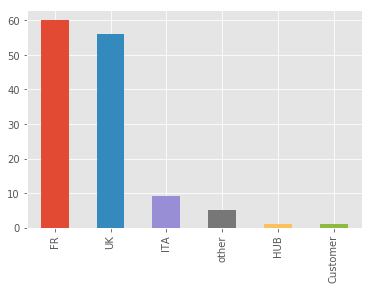

In [8]:
persons.country.value_counts().plot(kind = 'bar')

We can see that most of the employees are working in France and UK, with only slightly more people in France, and a small part of the compnay is located in Italy.

### Employees by position

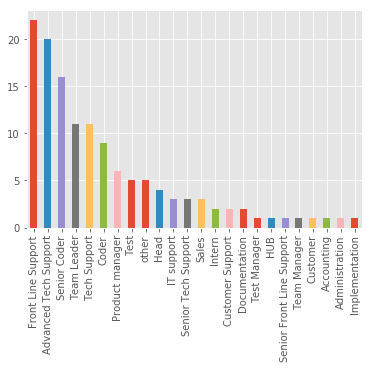

In [9]:
persons.position.value_counts().plot(kind = 'bar')

Various Support positions make up the largest part of employees, followed by Coding positions, and then management positions.

### Employees by country and department

In [136]:
def company_structure(persons, z, title, col, y_title): #col- 'dept' or 'position'
#    z=z.drop(columns=["assigner", "assignee", "position"])
    cols=persons[col].unique() #col="dept"
    #persons["country"].unique() #'other', 'UK', 'FR', 'ITA', 'Customer', 'HUB'
    dict={}
    for c in cols:
        d={"FR": 0, "UK": 0, "ITA": 0, "other": 0, "Customer": 0, "HUB": 0}
        dict[c]=d
    
    countries=list(z["country"])
    cols=list(z[col])
    worked=list(z["totalWorked"])    
#    assignees=list(persons["assignee"])
    
    #Number of employees per country and department:
    for i, c in enumerate(cols):
        country=countries[i]
#        dict[dept][countries[i]]=assignees[i]
        dict[c][countries[i]]=worked[i]
    
    countries_df= pd.DataFrame.from_dict(dict).T
    countries_df=countries_df.drop(columns=["Customer"]) #"HUB" each includes only one person, with no country and department
    countries_df=countries_df.drop(index=["Customer"]) 
    countries_df["total"]=countries_df["UK"]+ countries_df["FR"]+ countries_df["ITA"]+ countries_df["other"]+countries_df["HUB"]
    countries_df.sort_values(by=["total"], ascending=False, inplace=True)
    countries_df=countries_df.drop(columns=["total"])
    
    #Plotting number of employees by country and department:
    plt.figure();
    if "Average" in title:
        countries_df.plot(kind='bar', figsize=[25,5], fontsize=15); #, rot=50
    else:
        countries_df.plot(kind='bar', figsize=[25,5], stacked=True, fontsize=15); #, rot=50
        #plt.margins(0.2)
    plt.ylabel(y_title, fontsize=15)
    if col=="dept":
        plt.legend(fontsize=14)
        plt.xlabel('Departments', fontsize=15)
    else:
        plt.xlabel('Positions', fontsize=15)   
    plt.title(title, fontsize=16)

<Figure size 432x288 with 0 Axes>

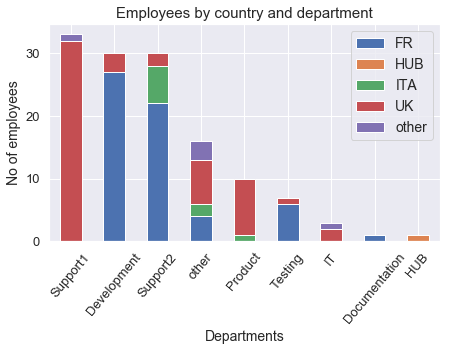

In [128]:
zz=persons.groupby(['dept', 'country'], as_index=False).count()
company_structure(persons, zz, "Employees by country and department", "dept", "No of employees")
#no_of_persons=list(z["totalWorked"])

We can see that the company is spread over three countries (France, Italy and UK), assuming that “HUB” is also located in one of those countries. The development activities are mainly carried out in France, and to a lesser degree also inUK, while in Italy they are only marketing their product. The largest department (over 33 people) is Support1, located in UK, followed by Support2 (30 people) mostly located in France, but partly also in Italy, and Development (also 30 people) mainly located in France, but with some employees also working in UK. Testing department(7 people) is also mostly located in France, bt also including one employee based in UK. On the other hand, Product department (10 people) is located in UK, with one person also working in Italy. In addition, there are a few very small departments offering internal services, like Documentation (2 people, in France), IT (2 people in UK and one unspecified) and HUB (comprising just one person). In case of 15 people, the department value has not been specified in the dataset. 

### Employees by country and position

<Figure size 432x288 with 0 Axes>

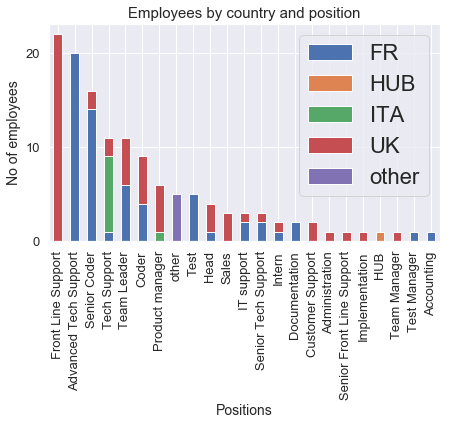

In [119]:
z3=persons.groupby(['position', 'country'], as_index=False).count()
company_structure(persons, z3, "Employees by country and position", "position", "No of employees")
no_of_persons=list(z3["totalWorked"])

Given the proportion of managers (team leaders, product and test managers and ‘heads’), the organisation’s hierarchical structure seems to be quite flat (they work in small teams). <br>

Out of the non-management positions, support people make up the largest part of the organisation. All Front Line Support positions are located in UK, while all Advanced Tech Support people are located in France. The Italian team consists only of Tech Support employees, and a Product Manager. These positions make up the largest part of the Support staff. There are also a few other Support positions (a few Tech Support employees in UK and France, Customer Support and Senior Front Line Support employees in UK, and IT Support, Senior Tech Support in UK and France. <br>

The Sales and Administration positions are located only in UK and Testing, Accounting and Documentation positions only in France. There has been one intern in UK and one in France.<br>

Also, it is interesting to note that all people missing department value (department is ‘other’), are also missing the country value. 

### Total worked hours by country and department

<Figure size 432x288 with 0 Axes>

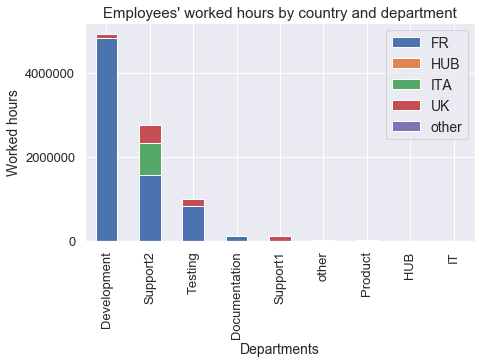

In [120]:
z1=persons.groupby(['dept', 'country'], as_index=False)["totalWorked"].sum()
company_structure(persons, z1,"Employees' worked hours by country and department", "dept",  "Worked hours")

We can see that employees in France and Italy are using the time recording, while in UK, only Support2 and Testing department are using it (we can note that in case of both these departments, the department is mostly based in France, with only some people working in UK).  Support1 (located in UK) is the largest department, but only one of its members is regularly recording working time. We can see that time recording is not regularly used the following departments: Support2, Product, IT and HUB. Also, persons with unspecified department value (whose department is ‘other’) have recrded close to zero working hours.

### Total worked hours by country and position

<Figure size 432x288 with 0 Axes>

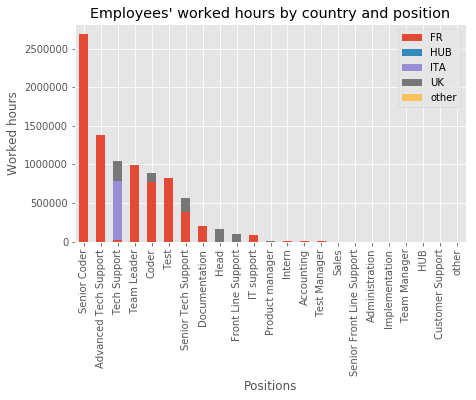

In [11]:
z4=persons.groupby(['position', 'country'], as_index=False)["totalWorked"].sum()
company_structure(persons, z4,"Employees' worked hours by country and position", "position", "Worked hours")

As seen from the graph, Senior Coders are the position who have contributed most working hours to the company. But when taking all tech support people a whole, they have contributed more than the coders over the three year period.  

### Average worked hours per employee by country and department

<Figure size 432x288 with 0 Axes>

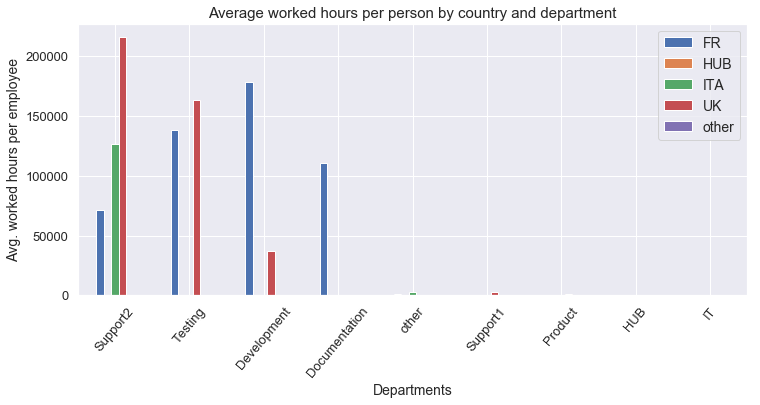

In [129]:
z2=persons.groupby(['dept', 'country'], as_index=False)["totalWorked"].mean()
company_structure(persons, z2,"Average worked hours per person by country and department", "dept", "Avg. worked hours per employee")

When looking at the average worked hours per employee (the plot above, which actually just combines the results of the two previous plots), we can see that out of the five departments who do use time recording, four do so regularily. Within those four, in some cases there are large differences between countries. For example, in the Development department, employees working in UK are either working much less or not recording their times as regularly as the employees in France. Reversely, In Support2 department, the employees based in  France are either working much less or not recording their worked hours regularily. 

### Average worked hours per employee by country and position

<Figure size 432x288 with 0 Axes>

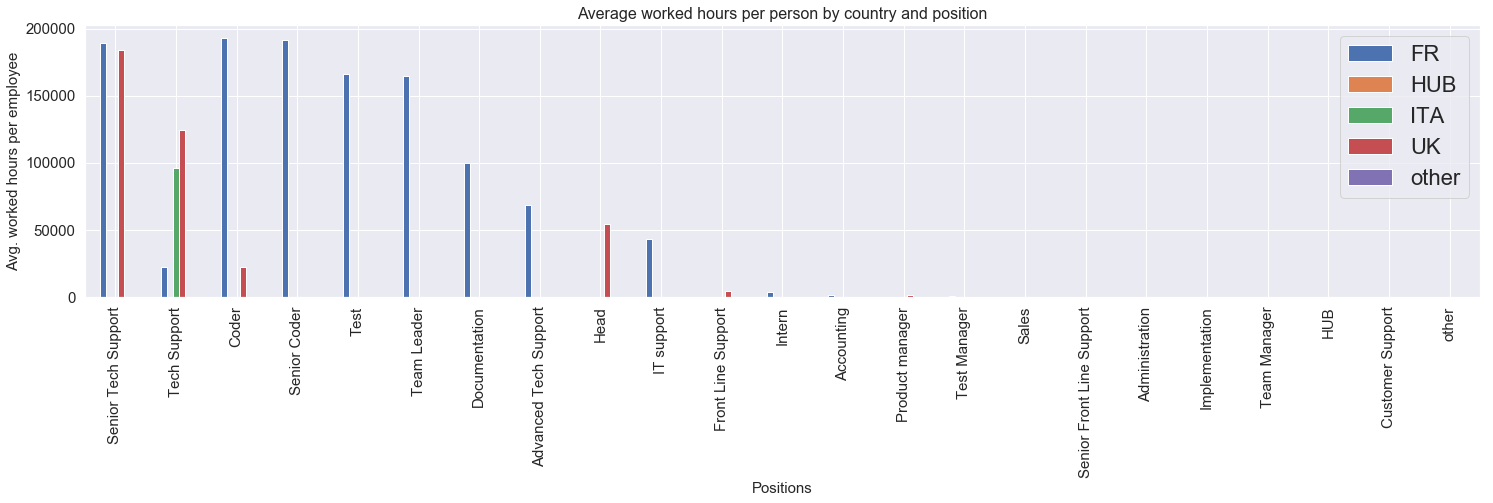

In [137]:
z5=persons.groupby(['position', 'country'], as_index=False)["totalWorked"].mean()
company_structure(persons, z5,"Average worked hours per person by country and position", "position", "Avg. worked hours per employee")

The efficiency, in terms of average recorded working hours, seems pretty similar in case of Coders, Senior Coders and Senior Tech Support positions, and somewhat lower for Testers and Team Leaders. The average worked hours of Tech Support and Documentation are already much lower. There are also marked differences between countries – coders in UK and Tech Support in France seem to be recording much less hours than their colleagues in France, and UK/Italy, respectively. While in case of some positions, like Heads, Accounting, Sales etc. the work assignments (or part of them) might be of different nature, and not recorded in this system for that reason, the differences of the worked hours of the same oosition (e.g. in case of coders) seems to indicate that there just are differences in practices between the departments, so that all work done is probably not being recorded. 

# 4. Analysis of workload over the years

For further analysis, it is necessary to do some further cleaning and updates to the main dataframe (removing some zero values and restructuring of the dates). We will leave out all the tasks that have not been completed yet or that have reported 0 minutes. We will also add the year and month column.

In [13]:
#Number of tasks woth zero WorkedMinutes:
tmp=list(log.groupby("ID")["WorkedMinutes"].mean()) #len 46367
#len(tmp)
non_nan=0
for el in tmp:
    if el>0:
        non_nan+=1
        
non_nan #30623
len(tmp) - non_nan  #number of nan values

15744

In [14]:
# We are going to leave out all the tasks that have not been completed yet and that reported 0 minutes
log['SignOff'] = log.SignOff.replace(' ', np.nan)
log['TotalMinutes'] = log.TotalMinutes.replace(0, np.nan)
log.dropna(inplace= True, subset=['TotalMinutes', 'SignOff'])
len(log)

210847

In [15]:
# parsing the datestamps (takes a few minutes (3 min.))
log['ActionTimeStamp'] = log['ActionTimeStamp'].apply(dateutil.parser.parse, dayfirst=True)
log['CreateTime'] = log['CreateTime'].apply(dateutil.parser.parse, dayfirst=True)
log['SignOff'] = log['SignOff'].apply(dateutil.parser.parse, dayfirst=True)

### Number of actions per task

In [16]:
# Number of actions per task 
data_groupedPerson= log.groupby('ID')['AssignedTo'].count()
data_groupedPerson
actions =[]
for value in data_groupedPerson:
    actions.append(value)
data_groupedPerson = pd.DataFrame(data_groupedPerson)
data_groupedPerson['ID'] = data_groupedPerson.index
data_groupedPerson.rename(columns={'AssignedTo': 'Actions'})
data = pd.merge(log, data_groupedPerson, on="ID")
log = data.rename(columns={'AssignedTo_x': 'AssignedTo', 'AssignedTo_y': 'Actions' })

C:\INSTALL\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 'ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
ax = sns.scatterplot(x="TotalMinutes", y="Actions", data=data)

ValueError: Could not interpret input 'Actions'

We can notice in general that a task lasts longer according to the number of actions that are performed in it

### Evaluate the workload per year

In [18]:
# Adding the year column
years = []
for i in log.ActionTimeStamp:
    years.append(i.year)
log['year'] = years

In [19]:
# Adding the month column
months = []
for i in log.ActionTimeStamp:
    months.append(i.month)
log['months'] = months

Text(0.5,0,'Months/Year')

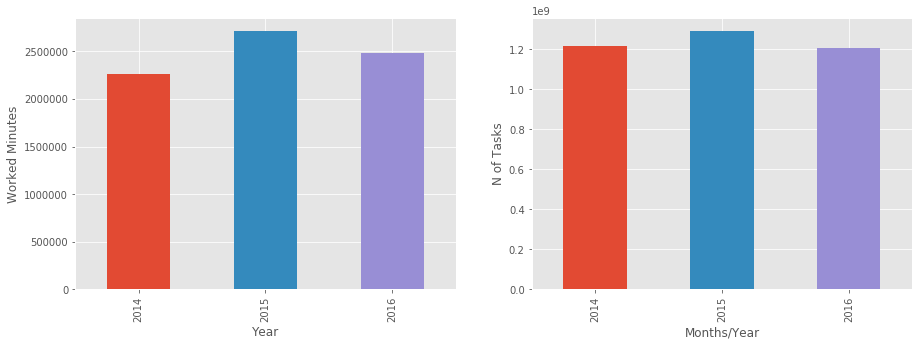

In [89]:
back = log.copy()
back.sort_values(by = 'TotalMinutes', ascending=False)
back.drop_duplicates(subset='ID', inplace=True)

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
log.groupby(['year'])['WorkedMinutes'].sum().plot(kind = 'bar')
plt.ylabel('Worked Minutes')
plt.xlabel('Year')

ax2 = f.add_subplot(122)
back.groupby(['year'])['ID'].sum().plot(kind = 'bar')
plt.ylabel('N of Tasks')
plt.xlabel('Months/Year')

2015 is the year where a higher amount of tasks and worked minutes is registred. We can notice that to a higher amount of tasks is corresponded, in general, a higher amount of worked minutes over the years

### Number of employees in each year

In [138]:
def number_of_employees_in_year(year):
    tmp=log[log["year"]==year]
    tmp2=set(list(tmp["AssignedTo"].unique()))
    tmp3=set(list(tmp["Creator"].unique()))
    tmp4=list(set(list(tmp3)+list(tmp2)))
    return len(tmp4)

In [141]:
emp_2014=number_of_employees_in_year(2014)
emp_2015=number_of_employees_in_year(2015)
emp_2016=number_of_employees_in_year(2016)
avg_emp=(emp_2014+ emp_2015+emp_2016)/3

print('2014: ', emp_2014)
print('2015: ', emp_2015)
print('2016: ', emp_2016)
print('Average: ', avg_emp)

2014:  93
2015:  97
2016:  111
Average:  100.33333333333333


### Evaluate the workload per month

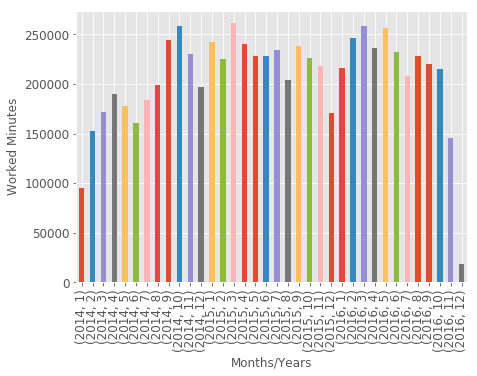

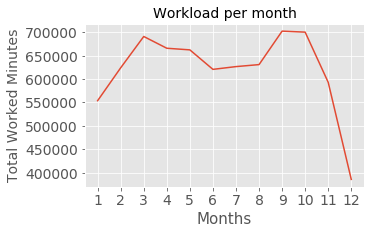

In [92]:
f = plt.figure(figsize=(7,5))
#ax = f.add_subplot(121)
work_over_years = log.groupby(['year','months'])['WorkedMinutes'].sum() #.mean()
#ind=work_over_years.index.values
#ind2=[str(x[0])+"-"+(str(x[1])) for x in ind]
#print(ind2)
work_over_years.plot(x = 'months', y= 'WorkedMinutes', kind = 'bar', fontsize=12)
#work_over_years.plot(x = 'months', y= 'WorkedMinutes', kind='line', fontsize=16, xticks=ind2)
plt.ylabel('Worked Minutes')
plt.xlabel('Months/Years')
plt.show()

#ax2 = f.add_subplot(122)
f = plt.figure(figsize=(5,3))
#log.groupby(['months'])['WorkedMinutes'].mean().plot(kind='line', fontsize=16, xticks=[x+1 for x in range(12)])
log.groupby(['months'])['WorkedMinutes'].sum().plot(kind='line', fontsize=14, xticks=[x+1 for x in range(12)])
plt.ylabel('Total Worked Minutes', fontsize=14)
plt.xlabel('Months', fontsize=15)
plt.title('Workload per month', fontsize=14)
plt.show()

If we look at the months, we cannot find a clear schema of the minutes worked for every task by employees. Just in general, we can say that April and May seem to be the months where there is more productivity, while the worked minutes tend to drop in August (probably because of the employees' annual leaves).

### Evaluate the Total Minutes over the months

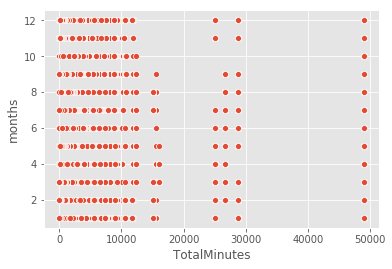

In [22]:
ax = sns.scatterplot(x="TotalMinutes", y="months", data=log)

As we can see from the scatterplot, there are certain tasks that lasted a significant amount of time dragging themselves in some cases over 1 year (in one occasion even 3 years) before signing off. Let's look which are these tasks and to which type they belong to

ID  ActionID         Type          CreateTime             SignOff  \
22052   114958   2342202  Enhancement 2014-04-14 20:11:00 2016-02-26 18:20:00   
89849   126820   2808886  Enhancement 2015-02-26 12:20:00 2016-09-09 12:42:00   
87557   126436   2795242  Enhancement 2015-02-17 16:57:00 2015-10-08 12:36:00   
67294   122836   2677402     Delivery 2014-11-19 14:24:00 2016-11-23 11:48:00   
90549   126937   2812860  Enhancement 2015-03-02 14:38:00 2015-12-04 15:20:00   
5662    112182   2266154  Enhancement 2014-01-30 20:11:00 2015-03-03 15:41:00   
80841   125135   2744036      Problem 2015-01-22 16:14:00 2015-12-03 10:55:00   
95900   127863   2848727  Enhancement 2015-03-25 12:06:00 2016-09-08 16:39:00   
74934   124160   2714333     Internal 2014-12-21 17:24:00 2016-01-04 11:49:00   
145275  136607   3170452  Enhancement 2015-12-01 18:05:00 2016-02-18 17:09:00   

          Source   Creator     ActionTimeStamp AssignedTo  TotalMinutes  \
22052   Internal    Alvaro 2014-04-14 20:11:00     Alvaro       48949.0   
89849   Internal    Landyn 2015-02-26 12:20:00     Landyn       28820.0   
87557   Internal    Alvaro 2015-02-17 16:57:00     Alvaro       26605.0   
67294   Internal    Eliana 2014-11-19 14:24:00     Eliana       24987.0   
90549   Internal  Michelle 2015-03-02 14:38:00     Lailah       15979.0   
5662    Internal     Rosie 2014-01-30 20:11:00      Rosie       15604.0   
80841   Internal  Angeline 2015-01-22 16:14:00   Michaela       15169.0   
95900   Internal  Brantley 2015-03-25 12:06:00   Brantley       12415.0   
74934   Internal  Anabella 2014-12-21 17:24:00   Anabella       11844.0   
145275  Internal    Eliana 2015-12-01 18:05:00     Alvaro       11636.0   

         ...    EstimateInMinutes  Category  SubCategory  AssigneeDept  \
22052    ...                 -1.0         7           15   Development   
89849    ...                 -1.0         7           96   Development   
87557    ...                 -1.0         7           28   Development   
67294    ...              10200.0         7          103   Development   
90549    ...               2400.0         7            2   Development   
5662     ...              15000.0        11          103   Development   
80841    ...               1200.0         5           90           HUB   
95900    ...                600.0        11          103       Testing   
74934    ...              12000.0         3          103      Support2   
145275   ...                 -1.0         2          103   Development   

        CreatorDept       AssigneePosition AssigneeCountry Actions  year  \
22052   Development           Senior Coder              FR     155  2014   
89849   Development  Advanced Tech Support              FR     117  2015   
87557   Development           Senior Coder              FR      91  2015   
67294   Development           Senior Coder              FR     127  2014   
90549   Development           Senior Coder              FR      42  2015   
5662    Development           Senior Coder              FR      41  2014   
80841      Support2                    HUB             HUB      51  2015   
95900       Testing                   Test              FR      90  2015   
74934      Support2           Tech Support             ITA     137  2014   
145275  Development           Senior Coder              FR      33  2015   

        months  
22052        4  
89849        2  
87557        2  
67294       11  
90549        3  
5662         1  
80841        1  
95900        3  
74934       12  
145275      12  

[10 rows x 21 columns]

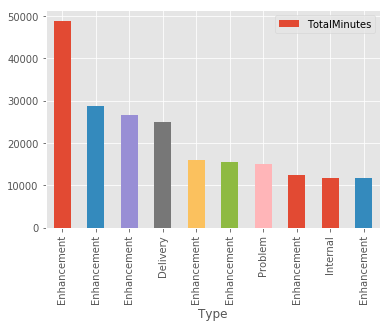

In [29]:
b = back.sort_values(by = 'TotalMinutes', ascending=False).head(10)
b.plot(y = 'TotalMinutes', x = 'Type', kind = 'bar')
b

### Categories were on average most worked minutes are spent

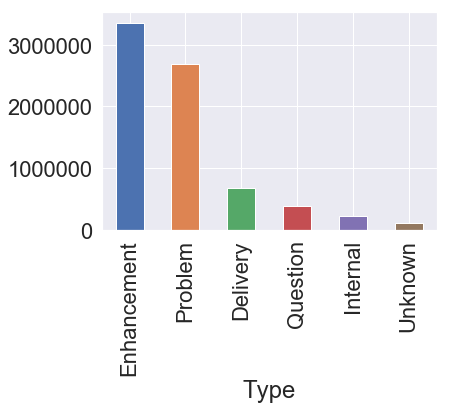

In [143]:
# find the categories were on average most worked minutes are spent
log.groupby(['Type'])['WorkedMinutes'].sum().sort_values(ascending = False).plot(kind = 'bar')

The tasks that exceed 20.000 minutes are 4 and they belong mostly to the type 'Enhancement' plus one task in Delivery. Overall, these are not the type categories where the highest values of worked minutes are spent. Let's look at the actions of these 4 tasks to look if we can find some mutual characteristics

In [144]:
loc = log.loc[log['ID'].isin([114958, 126820, 126436, 122836]) ]
with pd.option_context("display.max_rows", 1000):
    display(loc)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

By looking more deeply into these long-lasting tasks, we can notice that all of them have been taken care by one person only for each task and that the employee performed a high number of actions on them (> 90). Furthermore, all these employees belong to the same Department (Development), same category (n. 7) and they work in the same country as well, France. Importantly to notice is that these tasks were Internal and not provided by Customer. We can probably think of these tasks as some important optimizations of the company system that require a significative amount of time to be implemented and assigned to the some of the most expert developers in the company (Alvaro who has of these enhancements is a senior coder, as well as Eliana, while Landyn is an Advanced Tech Support)

In [145]:
# For the purpose of our model, we would like to predict standard tasks that require a total duration before 
# completing the task which is less than 1 year and for this reason we are going to leave out these outstanding cases
log.ID.drop(114958, inplace=True)
log.ID.drop(126820, inplace=True)
log.ID.drop(126436, inplace=True)
log.ID.drop(122836, inplace=True)

KeyError: '[114958] not found in axis'

### Number of employees reporting WorkedMinutes each year

In [94]:
# how many different employees reported the WorkedMinutes per every year
backup = log.copy()
df = pd.DataFrame(backup.groupby(['AssignedTo', 'year'], as_index= False)['WorkedMinutes'].agg(lambda x: x.mean() ))
df = df.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df = df.sort_values(by = ['year', 'WorkedMinutes'], ascending = False)
print(len(df.loc[df.year == 2016]))
print(len(df.loc[df.year == 2015]))
print(len(df.loc[df.year == 2014]))

60
45
49


We can see that out of the 122 employees present in the data, only a maximum of 60 influenced the WorkedMinutes in a single year

### Distribution of the average worked minutes of employees per year

Text(0.5,0,'2014')

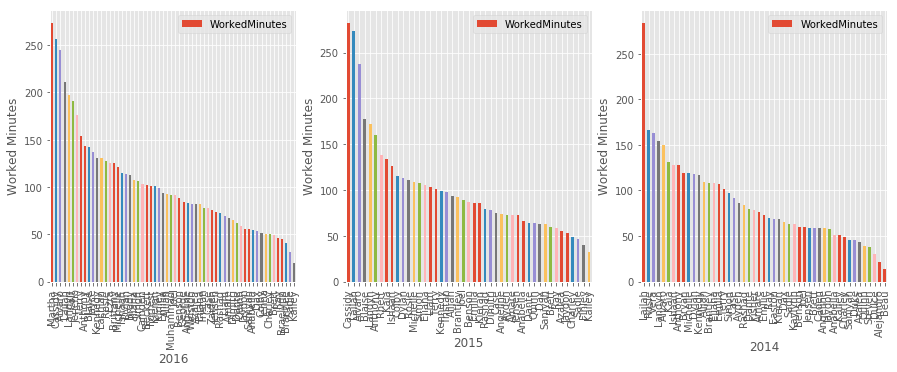

In [95]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(131)
df.loc[df.year == 2016].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax)
plt.ylabel('Worked Minutes')
plt.xlabel('2016')

ax2 = f.add_subplot(132)
df.loc[df.year == 2015].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax2)
plt.ylabel('Worked Minutes')
plt.xlabel('2015')

ax3 = f.add_subplot(133)
df.loc[df.year == 2014].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax3)
plt.ylabel('Worked Minutes')
plt.xlabel('2014')

The distribution is similar over the years for employees worked minutes

### Employees contributing most WorkedMinutes to the company

In [96]:
# The 10 employees that reported more WorkedMinutes on average for one year in all 3 years
df2 = pd.DataFrame(backup.groupby(['AssignedTo', 'year'])['WorkedMinutes'].agg(lambda x: x.mean() ))
df2 = df2.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df2[:10]

WorkedMinutes
AssignedTo year               
Lailah     2014     284.262604
Cassidy    2015     282.535461
Martha     2016     273.666656
Lailah     2015     273.301422
Cassidy    2016     256.645599
Alvaro     2016     244.591461
           2015     237.943207
Lailah     2016     211.000000
Landyn     2016     197.610779
Colt       2016     190.687500

In [97]:
# The 10 employees that on average reported the most worked minutes in all 3 years
df3 = pd.DataFrame(backup.groupby(['AssignedTo'])['WorkedMinutes'].agg(lambda x: x.mean() ))
df3 = df3.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df3[:10]

WorkedMinutes
AssignedTo               
Martha         273.666656
Cassidy        269.522034
Lailah         261.456055
Alvaro         204.956055
Colt           190.687500
Jericho        176.477066
Landyn         173.417267
Vera           163.292160
Blaise         151.320679
Anthony        143.026703

In [98]:
# the 10 employees that spent the most worked minutes per year
df2 = pd.DataFrame(backup.groupby(['AssignedTo', 'year'])['WorkedMinutes'].agg(lambda x: x.sum() ))
df2 = df2.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df2[:10]

WorkedMinutes
AssignedTo year               
Anabella   2015       114406.0
Kieran     2015       100454.0
Lailah     2015        97022.0
Alvaro     2015        96367.0
Anabella   2016        96242.0
Jaydon     2015        93545.0
Rosie      2015        93076.0
Brett      2015        89371.0
Rosie      2014        88616.0
Dante      2014        88207.0

In [99]:
# the 10 employees that on average reported the most worked minutes in all 3 years
df3 = pd.DataFrame(backup.groupby(['AssignedTo'])['WorkedMinutes'].agg(lambda x: x.sum() ))
df3 = df3.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df3[:10]

WorkedMinutes
AssignedTo               
Jaydon           263030.0
Rosie            259417.0
Anabella         253883.0
Ray              235693.0
Brett            220227.0
Lailah           220146.0
Rashad           218889.0
Charley          217603.0
Case             211118.0
Michelle         208839.0

In [100]:
# The highest amount of worked minutes on average per task per employee
df3 = pd.DataFrame(backup.groupby(['ID', 'AssignedTo','Type'])['WorkedMinutes'].agg(lambda x: x.mean() ))
df3 = df3.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df3.loc[df3['WorkedMinutes'] > 10][:10]

WorkedMinutes
ID     AssignedTo Type                      
118322 Rosie      Enhancement     722.000000
119404 Alvaro     Enhancement     713.000000
121764 Michelle   Internal        708.000000
137562 Benson     Delivery        689.500000
153861 Michelle   Internal        667.500000
113211 Michelle   Internal        654.500000
155404 Michelle   Delivery        649.400024
154508 Charley    Unknown         630.000000
113956 Michelle   Enhancement     600.000000
134851 Michelle   Unknown         597.000000

# 5. Employee efficiency (i.e. average worked minutes by task) 

First, we will constuct a dataframe for analysing employee efficiency (sum up the WorkedMinutes in cases where same person has completed several actions within a task, and leave out some columns that are not necessary for the analysis):

In [101]:
#Worked minutes per task per person (with all other relevant properties of a task):
efficiency=pd.DataFrame(log.groupby(['ID', 'AssignedTo', 'Type', 'Source', 'Creator', 'Category', 'SubCategory', 'AssigneeDept', 'CreatorDept', 'AssigneePosition', 'AssigneeCountry', 'Actions', 'year'], as_index=False)['WorkedMinutes'].sum())

#In case of tasks that carried on from one year to the next, take the average year:
eff=pd.DataFrame(efficiency.groupby(['ID', 'AssignedTo', 'Type', 'Source', 'Creator', 'Category', 'SubCategory', 'AssigneeDept', 'CreatorDept', 'AssigneePosition', 'AssigneeCountry', 'Actions', 'year'], as_index=False)['year'].agg(lambda x: int(round(x))))

eff.reset_index(inplace=True) #multiindex into columns
eff[0]=efficiency['WorkedMinutes'] #replacing the resulting column name '0' with 'WorkedMinutes'
cols=list(eff.columns.values)
cols[-1]='WorkedMinutes'
eff.columns=cols
#eff.rename(columns=cols, inplace=True)
del efficiency
#tmp=eff[:500]

#Remove cases where average worked minutes is zero:
eff=eff[eff['WorkedMinutes']>0]

Now we can start analysing employee efficiency (average time spent on a task). First we will analyse the efficiency by department, and then by individual employees, given their department and country (also by year). 

### Overall efficiency (avg. worked minutes per task)

In [102]:
#Average worked minutes per person per task (only taking into account tasks where the person has recorded 
#worked minutes):
overall_avrage=eff['WorkedMinutes'].mean()
overall_avrage #171.29

171.29441833496094

In [103]:
#Overall average, split by years:
overall_avg_years=eff.groupby(['year'])['WorkedMinutes'].mean()
overall_avg_years

year
2014    163.584900
2015    172.766388
2016    177.248444
Name: WorkedMinutes, dtype: float32

We can see that average time spent by a person on a task has increased over the years.

In [104]:
def df_average(eff, col1, col2):
    type_position = eff.groupby([col1, col2], as_index=False)['WorkedMinutes'].mean()
    
    types=list(type_position[col1].unique())
    positions=list(type_position[col2].unique())
    type_pos=pd.DataFrame(columns=types, index=positions, data=0)
    
    for i in range(len(type_position)):
        type=type_position[col1][i]
        position=type_position[col2][i]
        type_pos[type][position]=int(round(type_position['WorkedMinutes'][i]))
    return type_pos
    

In [161]:
def draw_heatmap(tab):
    fig, ax = plt.subplots(figsize=(14,7))
    sns.heatmap(tab, annot=True, linewidths=0.1,  cbar=True, fmt='g', vmax=750, vmin=50,
               xticklabels=True, yticklabels=True,  ax =ax) #center=0.05, fmt='.1g'
    
# , annot_kws={"size": 9}
    sns.set(font_scale=1.5)
    plt.show()

### Efficiency by position, given the task type

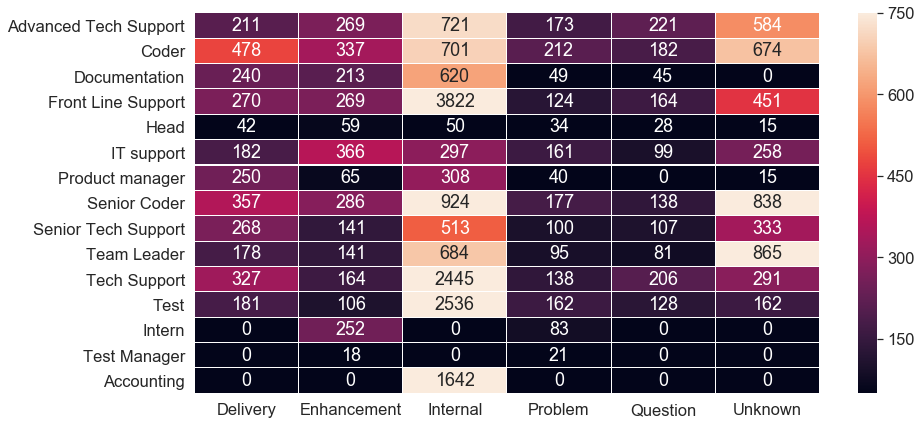

In [162]:
#Average time it takes a person to complete a task, given the task type and assignee position:
type_pos=df_average(eff, 'Type', 'AssigneePosition')
draw_heatmap(type_pos)

We can see that 'Internal' tasks are more time-consuming than any other type of task. Among these, Front Line Support position has the longest tasks. The shortest type of tasks are problems and questions. We can also see that testers have roughly four times longer internal tasks than coders. 

### Efficiency by department, given the task type

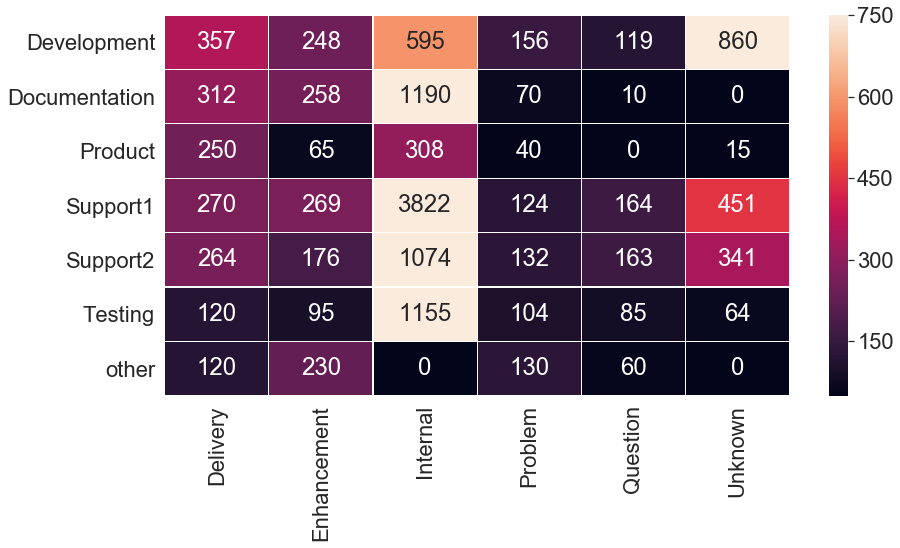

In [46]:
##Average time it takes a person to complete a task, given the task type and assignee department:
type_pos=df_average(eff, 'Type', 'AssigneeDept')
draw_heatmap(type_pos)

The internal tasks of Support1 department (located mostly in UK) clearly seems to stand out in terms of task length. At the same time, as we have seen above, only very few persons from Support1 are recording their working hours, and therefore this high figure is not representative of the actual efficiency of that department. 

### Efficiency by department, given the country of location

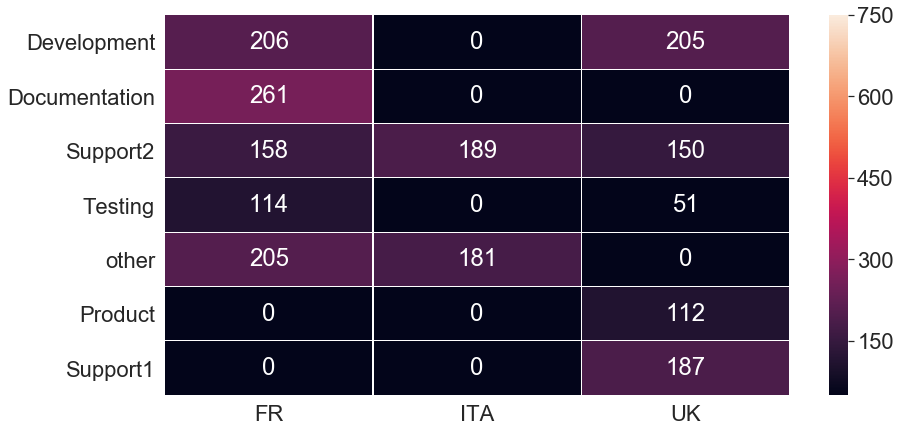

In [48]:
##Average time it takes a person to complete a task, given the assignee department and country:
type_pos=df_average(eff, 'AssigneeCountry', 'AssigneeDept')
draw_heatmap(type_pos)

In this plot, we can see differences between countries in case of departments that have employees working in more than one country. Otherwise those differences within individual departments are not large, except that it seems that the members of the Italian team of Support2 work on average longer on a task than their teammates in France and UK. 

### Efficiency by department, given the category of task

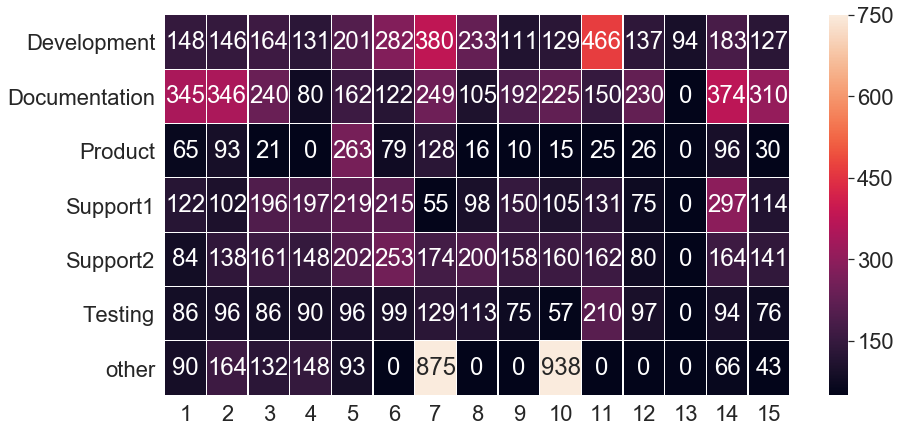

In [49]:
###Average time it takes a person to complete a task, given the category and assignee department:
type_pos=df_average(eff, 'Category', 'AssigneeDept')
draw_heatmap(type_pos)

It is interesting to note that category 13 only includes tasks of the Development department, while other categories include all or nearly all different types of tasks. Development department is dealing with all possible categories of tasks. It is also the only department that deals with category 

### Efficiency by department, given the source ('Internal' or 'Customer') 

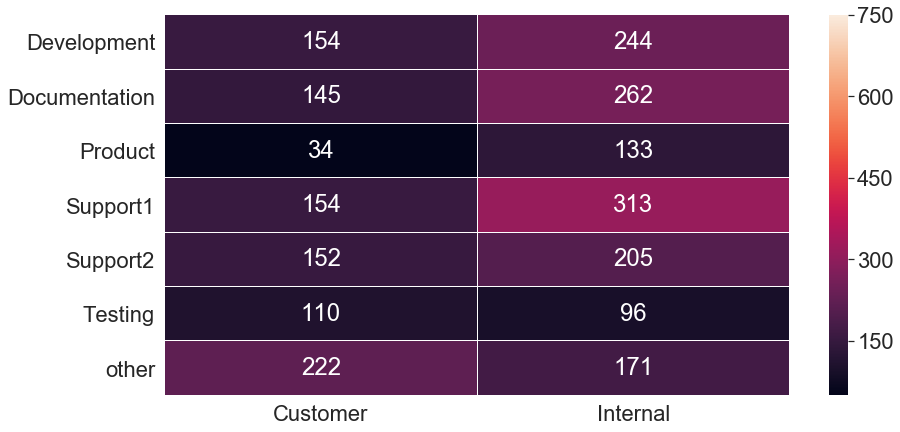

In [50]:
###Average time it takes a person to complete a task, given the source ('Internal' or 'Customer') and 
#assignee department
type_pos=df_average(eff, 'Source', 'AssigneeDept')
draw_heatmap(type_pos)

Internal tasks take longer than the ones driven by the customer. 

## Which departments assign tasks to which departments

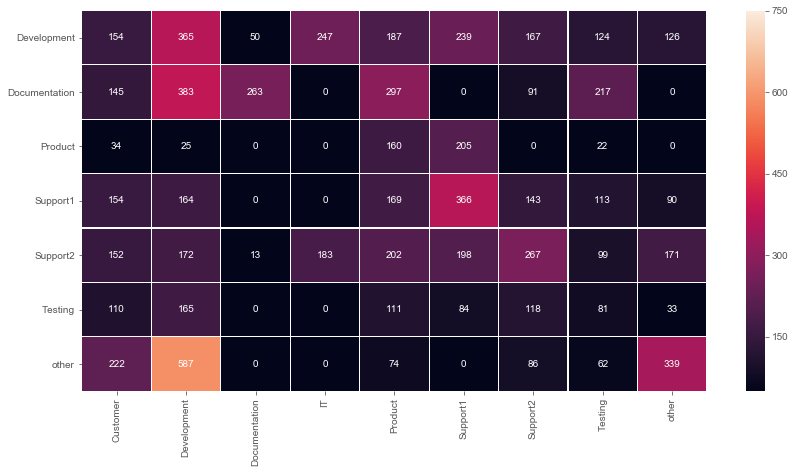

In [107]:
#Which departments assign tasks to which departments:
type_pos=df_average(eff, 'CreatorDept', 'AssigneeDept') #1st value- on x-axis
draw_heatmap(type_pos)

## Graph of task assignments
By using the dataframe <code>eff</code>, constructed for the purpose of measuring employee efficiency, we can also draw an interesting graph on which department is assigning tasks to each other department. 

In [108]:
#Adding two rows, because for drawing the graph we need to have all rows and columns with same names represented:
#type_pos=type_pos.drop(columns=["Customer"])
depts=list(type_pos.columns.values)
to_add=pd.DataFrame(columns=["Customer"], data=[0 for x in range(len(depts))])
to_add["IT"]=[0 for x in range(len(depts))]
to_add=to_add.T
#type_pos=type_pos.drop(index="HUB")
to_add.columns=list(type_pos.columns.values)
type_pos=type_pos.append(to_add)

In [109]:
type_pos

Customer  Development  Documentation   IT  Product  Support1  \
Development         154          365             50  247      187       239   
Documentation       145          383            263    0      297         0   
Product              34           25              0    0      160       205   
Support1            154          164              0    0      169       366   
Support2            152          172             13  183      202       198   
Testing             110          165              0    0      111        84   
other               222          587              0    0       74         0   
Customer              0            0              0    0        0         0   
IT                    0            0              0    0        0         0   

               Support2  Testing  other  
Development         167      124    126  
Documentation        91      217      0  
Product               0       22      0  
Support1            143      113     90  
Support2            267       99    171  
Testing             118       81     33  
other                86       62    339  
Customer              0        0      0  
IT                    0        0      0

C:\INSTALL\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\INSTALL\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\INSTALL\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\INSTALL\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
C:\INSTALL\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: Matplot

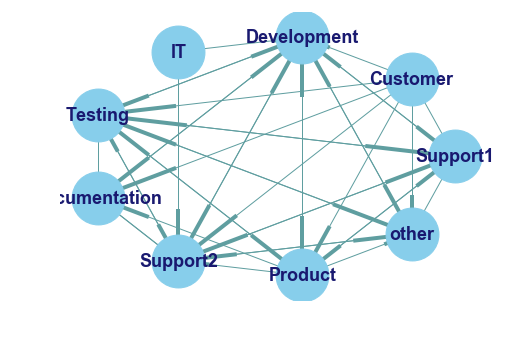

In [110]:
#Drawing the graph:
plt.figsize=[80, 50]
#plt.axis('equal')
DG = nx.DiGraph()
DG.add_nodes_from(depts)

edges=[]
for dept1 in depts:
    for dept2 in depts:
        if type_pos[dept1][dept2]!=0:
            edges.append((dept1, dept2, type_pos[dept1][dept2]/50))
            
DG.add_weighted_edges_from(edges)
#DG.degree(1, weight='weight')
#list(DG.successors("Support1")) #['Support1', 'Product', 'Customer', 'Testing', 'Support2', 'Development', 'IT']

#colors = range(20)
#pos = graphviz_layout(DG, prog='twopi', args='')  #darkseagreen #

nx.draw_circular(DG, with_labels=True, font_weight='bold', font_color='midnightblue', font_size= 18, node_size=2800, 
                 node_color='skyblue', edge_color='cadetblue', arrowstyle='->') #arrowstyle='->' node_color='#A0CBE2'
#>>> G = nx.dodecahedral_graph()
#edge_labels = nx.draw_networkx_edge_labels(DG, pos=nx.spring_layout(DG)) #font_size=20, 
#plt.figsize=[15, 15]
plt.show()

The bold parts of the edges show direction and weight of the edge (i.e. the average size of a task assigned from one department to another, measured as WorkedMinutes per employee).

We can see, for example, that Customer is assigning, and not receiving tasks. We can see that, with only a few exceptions, all departments are both assigning tasks to every other department, and also accepting tasks from them. An exception is the IT depertment, which is only assigning, and not accepting tasks. Another exeprion us The documentation department, who doesn't assign tasks to Testers, but is only accepting tasks from them. From the heatmap we can also see that every department is also assigning tasks to itself. 

## Efficiency (avg. time spent on a task) of individual employees by department and country

The nature of of work assignments may be different in different departments. Therefore, it would be useful to compare the efficiency of employees separately for each department.

In [126]:
eff["country+dept"]=eff["AssigneeDept"]+" - " + eff["AssigneeCountry"]
depts=list(eff['country+dept'].unique()) #len 12 (depts total 7, but some in different countries)
d_supp1UK=eff[eff['country+dept']=='Support1 - UK']
d_supp2FR=eff[eff['country+dept']=='Support2 - FR']
d_supp2IT=eff[eff['country+dept']=='Support2 - ITA']
d_supp2UK=eff[eff['country+dept']=='Support2 - UK']
d_devFR=eff[eff['country+dept']=='Development - FR']
d_devUK=eff[eff['country+dept']=='Development - UK']
d_testingUK=eff[eff['country+dept']=='Testing - UK']
d_testingFR=eff[eff['country+dept']=='Testing - FR']
d_docFR=eff[eff['country+dept']=='Documentation - FR']
d_prodUK=eff[eff['country+dept']=='Product - UK']
d_otherFR=eff[eff['country+dept']=='other - FR']
d_otherIT=eff[eff['country+dept']=='other - ITA']

df_depts=[d_supp1UK, d_supp2FR, d_supp2IT, d_supp2UK, d_devFR, d_devUK, d_testingUK, d_testingFR, d_docFR, d_prodUK, d_otherFR, d_otherIT]
dept_names=["Support-1 (UK)", "Support-2 (FR)", "Support-2 (ITA)", "Support-2 (UK)", "Development (FR)", "Development (UK)", "Testing (UK)", "Testing (FR)", "Documentation (FR)", "Product (UK)", "Other (FR)", "Other (ITA)"]

In [129]:
def efficiency_by_department(df, department, col, x_title): 
    y_title='Avg. minutes per task'
    plot_dfs=[]
    years=[2014, 2015, 2016]
    for year in years:
        df_year=df[df['year']==year]
        df_year=df_year.drop(columns=['year'])
        cols=list(df_year[col].unique()) 
        
        dict={}
        for c in cols:
            d={}
            for a in df_year["AssignedTo"].unique():
                d[a]=0
            dict[c]=d
    
        cols=list(df_year[col])
        worked=list(df_year["WorkedMinutes"])    
        assignees=list(df_year["AssignedTo"])
    
        #Avg. worked hours per employee by department:
        for i, c in enumerate(cols):
            assignee=assignees[i]
            dict[c][assignee]=worked[i]
    
        plot_df= pd.DataFrame.from_dict(dict).T
        plot_dfs.append(plot_df)

#    Plotting employee efficiency by year and department:
    for i in range(len(plot_dfs)):
        plot_df=plot_dfs[i]
        no_of_persons=len(plot_df.columns.values)
        if no_of_persons>0: #don't plot an empty dataframe
            if no_of_persons<6:
                plot_df.plot(kind='bar', title= department + " (" + str(2014+i) + ")", figsize=[6,4], fontsize=16)
            elif no_of_persons<12:
                plot_df.plot(kind='bar', title= department + " (" + str(2014+i) + ")", figsize=[12,8], fontsize=16)
            elif no_of_persons>=12:
                plot_df.plot(kind='bar', title= department + " (" + str(2014+i) + ")", figsize=[18,12], fontsize=16)
            plt.ylabel(y_title, fontsize=16)
            plt.xlabel(x_title, fontsize=16)
            plt.legend(loc='upper right', fancybox=True, fontsize='xx-small')

### Efficiency of individual employees by type of task, by department, country and year
The plots below have been drawn by country and department, in order to enable analysing also the differences within a department in case it is split between different countries (as some departments are).

A separate plot has been drawn for each year in order to make it possible to look at changes over the years.

C:\INSTALL\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


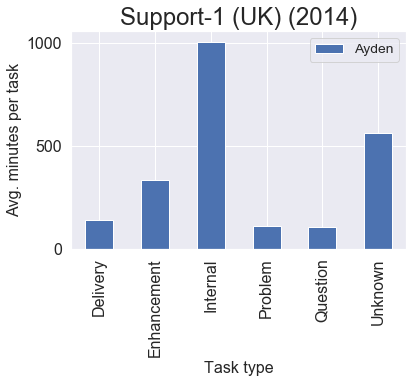

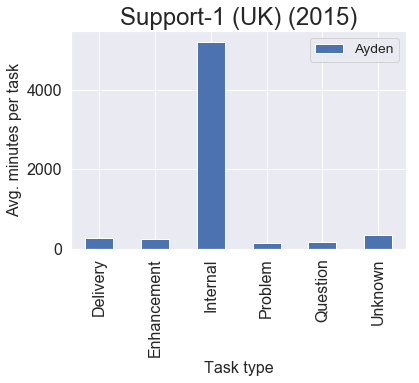

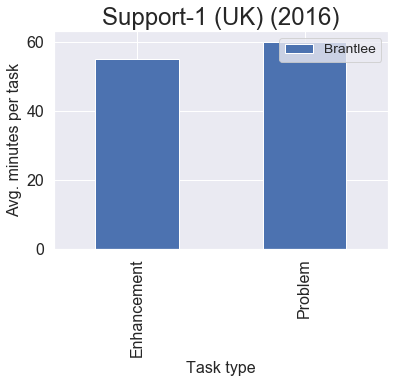

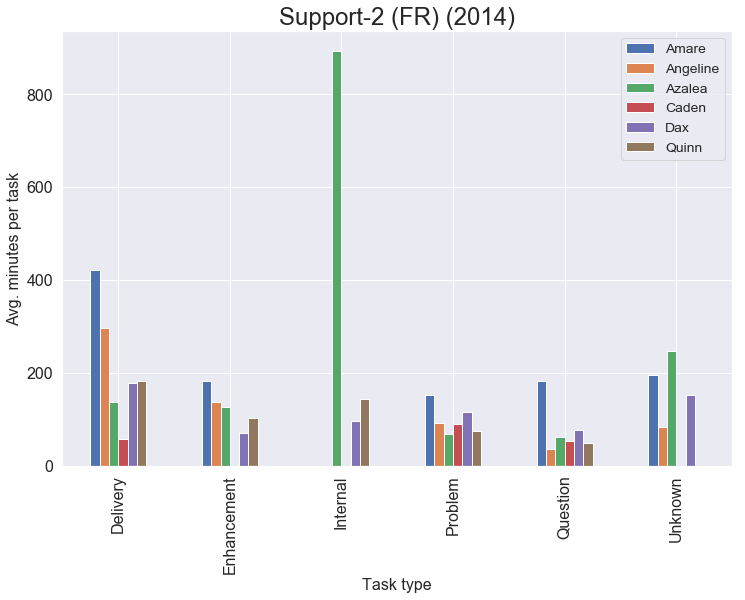

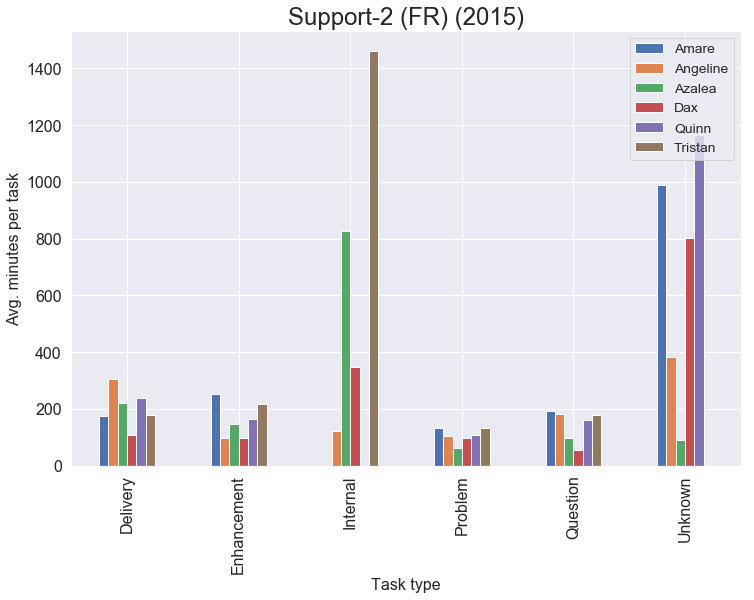

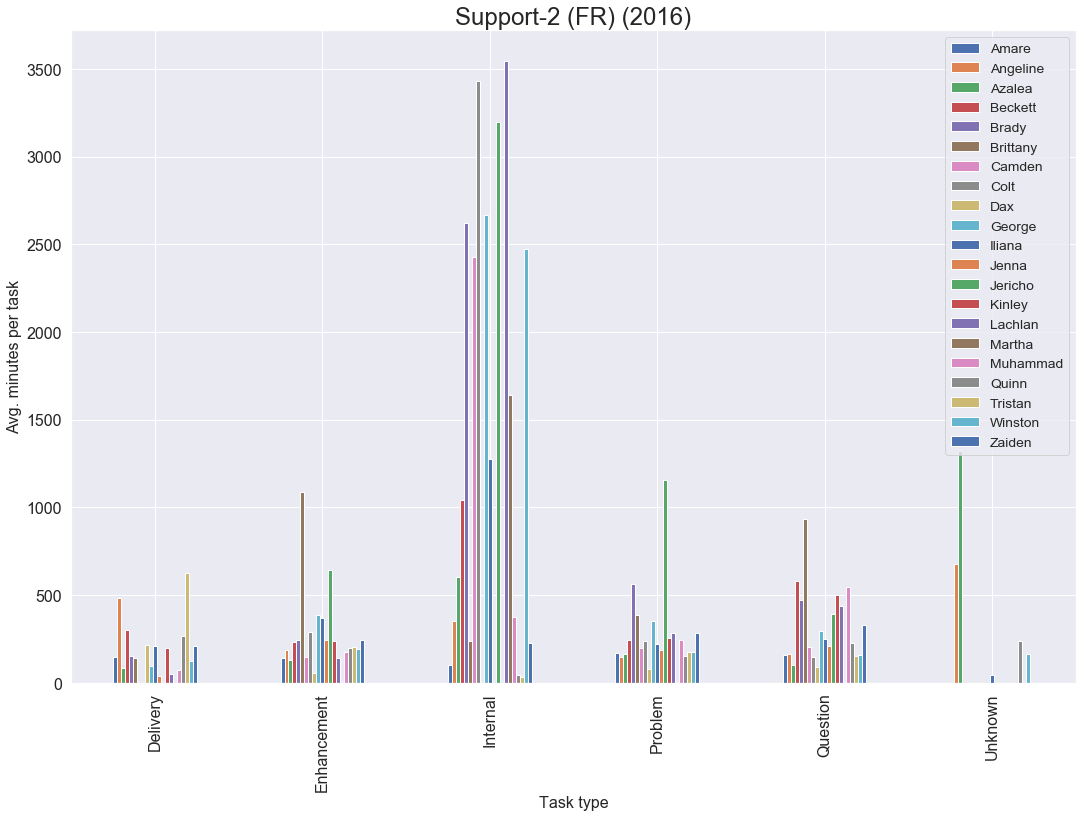

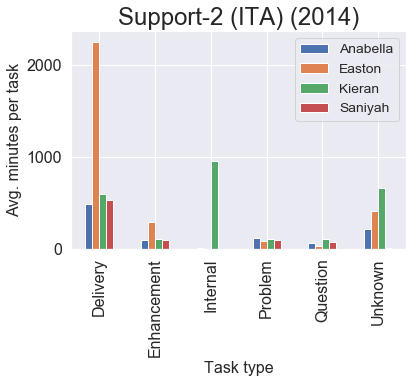

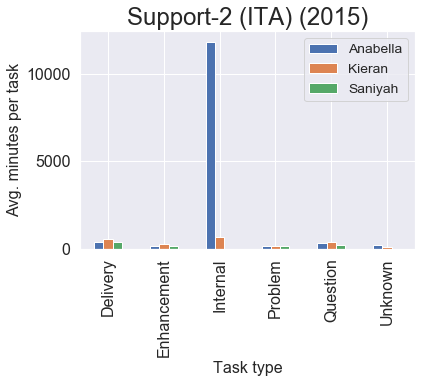

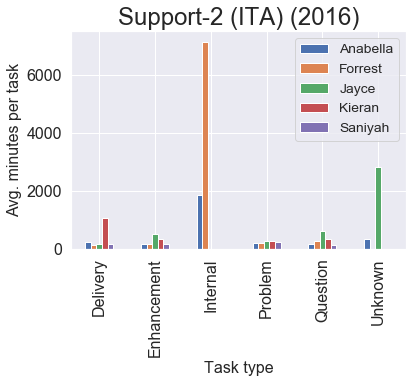

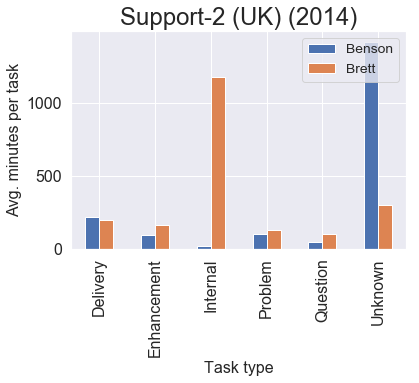

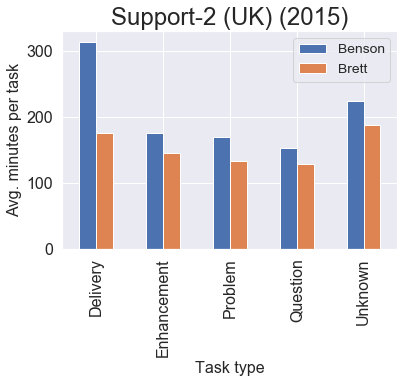

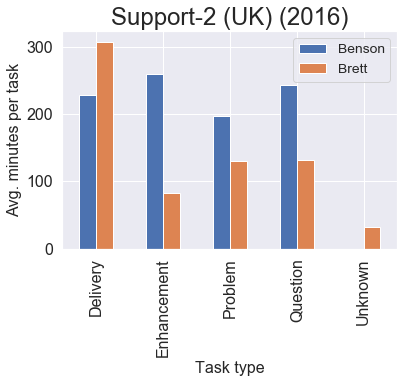

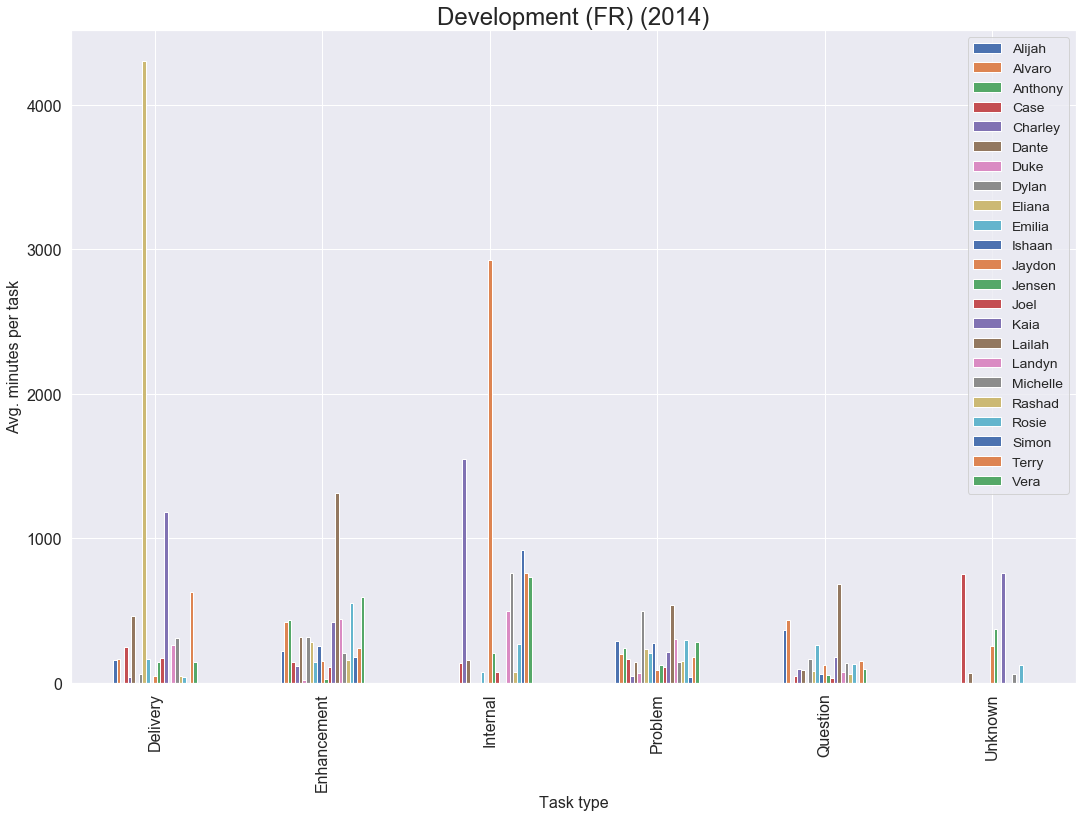

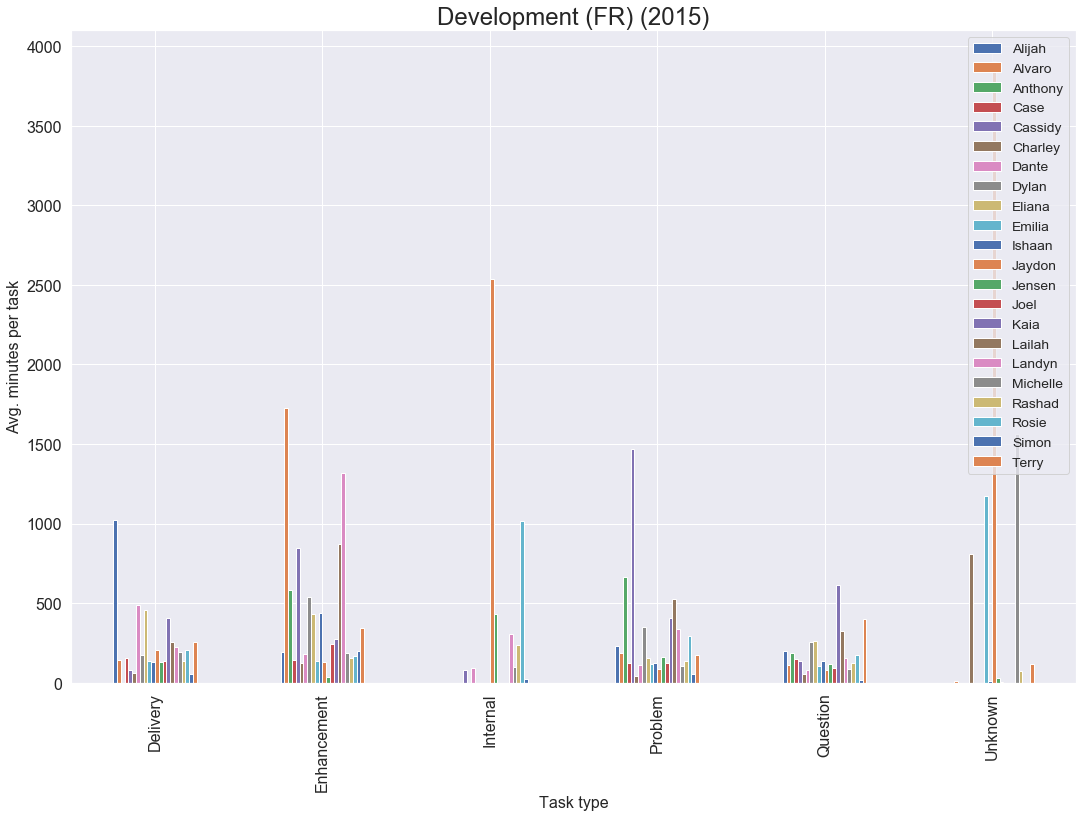

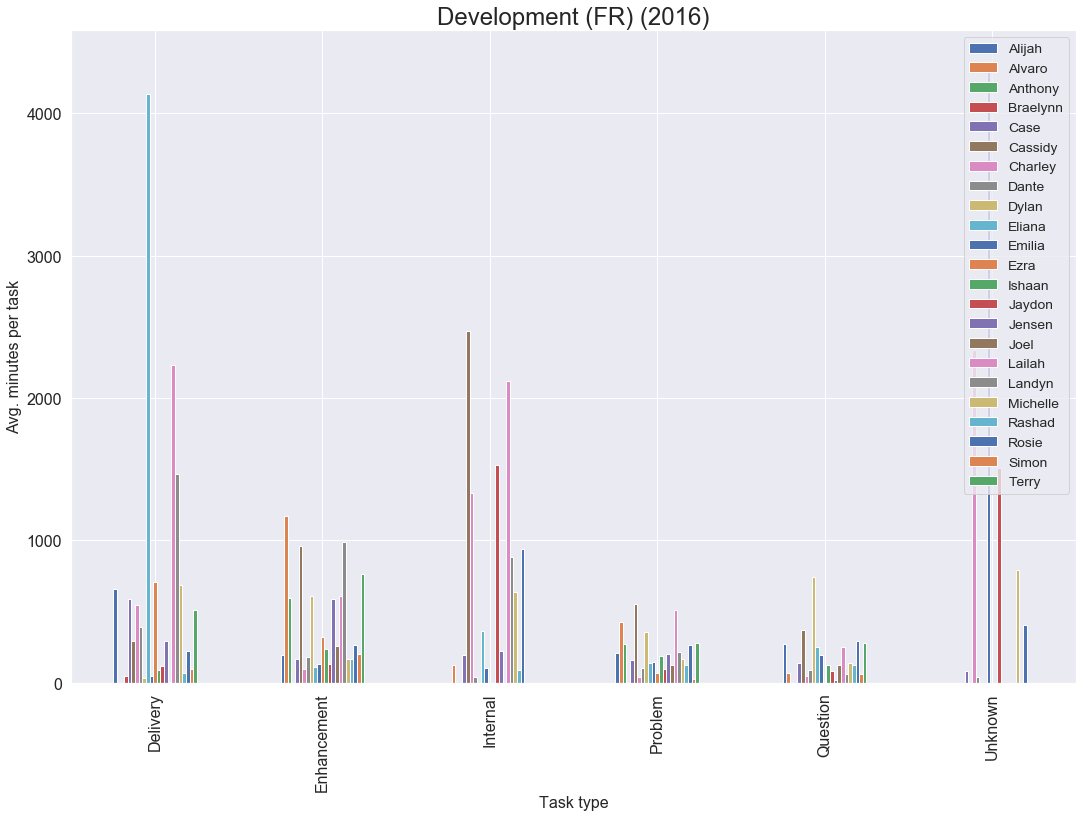

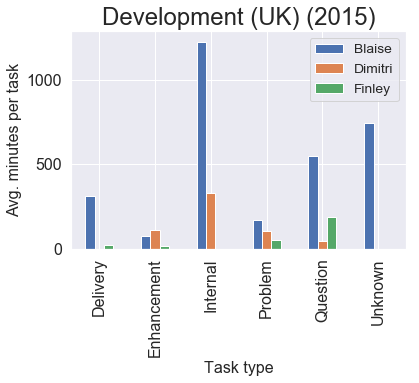

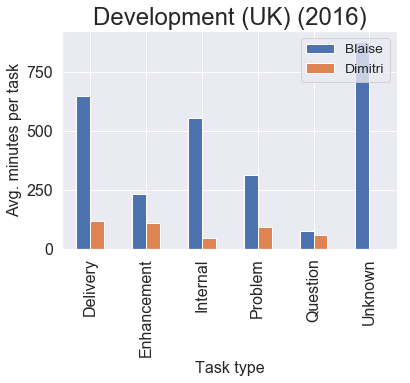

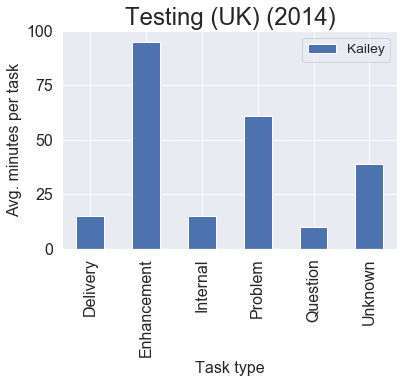

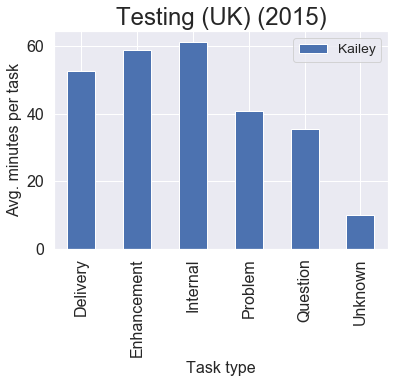

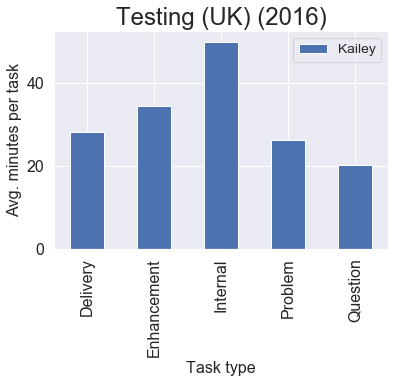

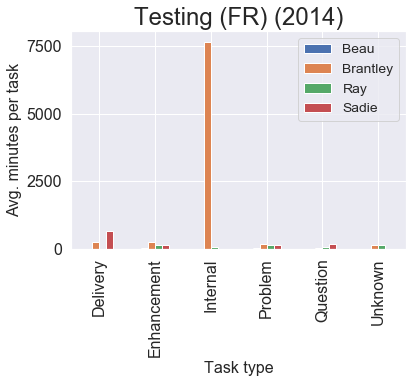

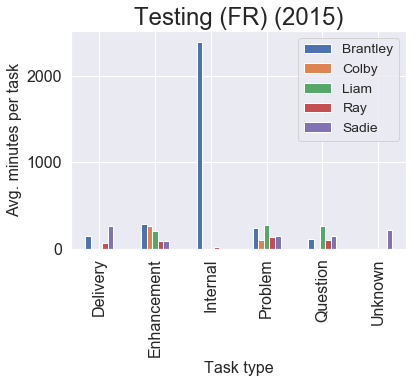

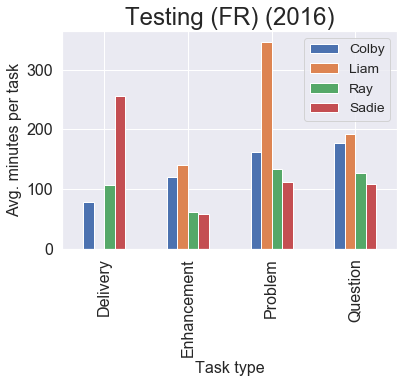

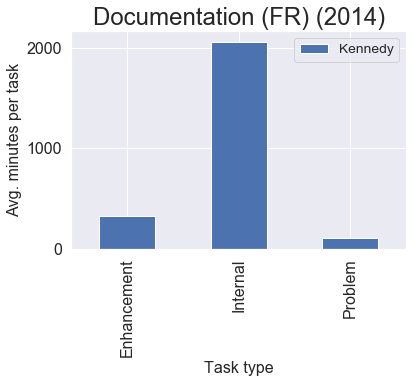

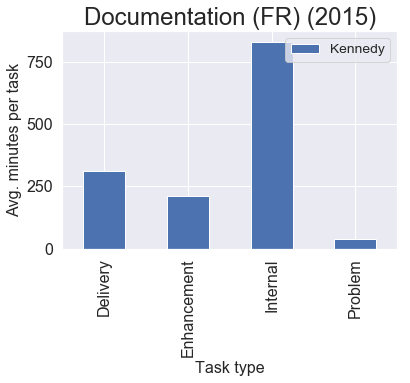

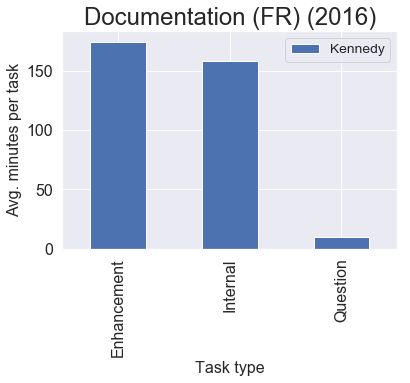

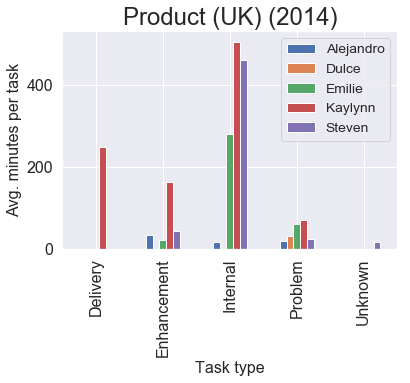

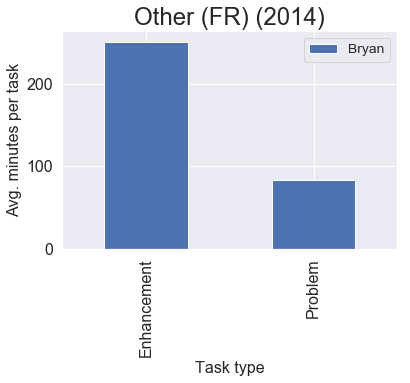

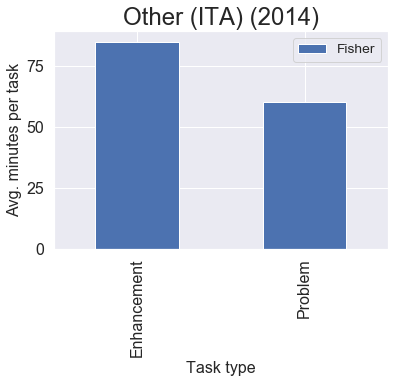

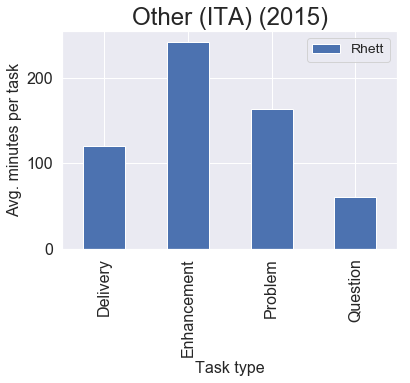

In [130]:
#Plotting employee efficiency by type of task, by department and year:
col="Type"
x_title='Task type'

for i, el in enumerate(df_depts):
    df=el
    df=pd.DataFrame(df.groupby(['AssignedTo', col, 'year'], as_index=False)['WorkedMinutes'].mean())
    department=dept_names[i]
    efficiency_by_department(df, department, col, x_title)

We can see that in some cases, the avg. task completion time of a single employee in solving certain type of task clearly stands out (is several times longer than for any of his/her colleagues). This may be caused by this person being assigned some specific tasks that take much longer, and are not typical task in this department. 

The plots containig only one employee are not that informative, but still give an overview of the changes in this person's efficiency over the years when solving different types of tasks. 

The plots for Support-2 department show that the number of employees recording working times increased sharply - from 6 persons in 2014 and 2015 to 21 persons in 2016. This shows that either there was a major restructuring or hiring of additional people that resulted in a large increase of the department size, or that a change in the practices of recording working times was implemented by management. 

When not taking into account the outliers (cases where avg. task completion time of a single person is several times higher than that of his/her colleagues in the same department), we can notice that persons who perform one type of task faster than average, quite often also perform most of the other types of task faster than average. This means that they are in general better performers. 

The plots allow to analyse which employees within a department are in general better performers, and who are not performing that well. The management may use this information to decide wether the people not performing that well would need further training or mentoring, which could increase their efficiency. They could also use that information for better balancing the workload. For example, if a person is more efficient in solving certain types of tasks than others, it might be useful to assign these types of tasks to this person, and other types of tasks to persons who are performing better those tasks. 

In case it turns out that the reason for 'not performing so well' is that the persons concerned are just more accurate in recording their working time (leave time unrecorded in less cases), the management could use that information to ask the employees who are not accurately reporting their worked minutes to do this more accurately, so that similar analysis as the one performed in this project would give more realistic picture of the situation (comparison of employees in a department), which could also be more useful for making management decisions. 

### Efficiency of individual employees by source (internal / customer), by department, country and year

C:\INSTALL\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


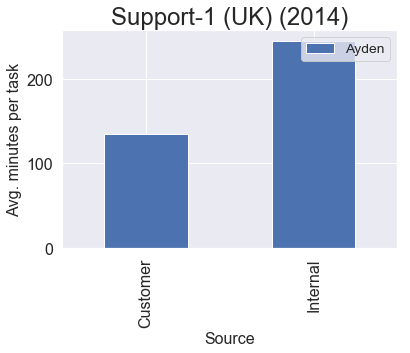

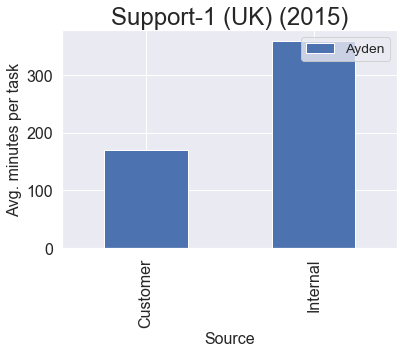

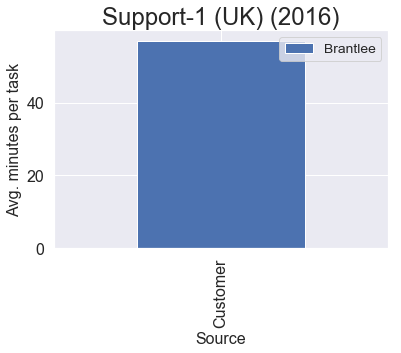

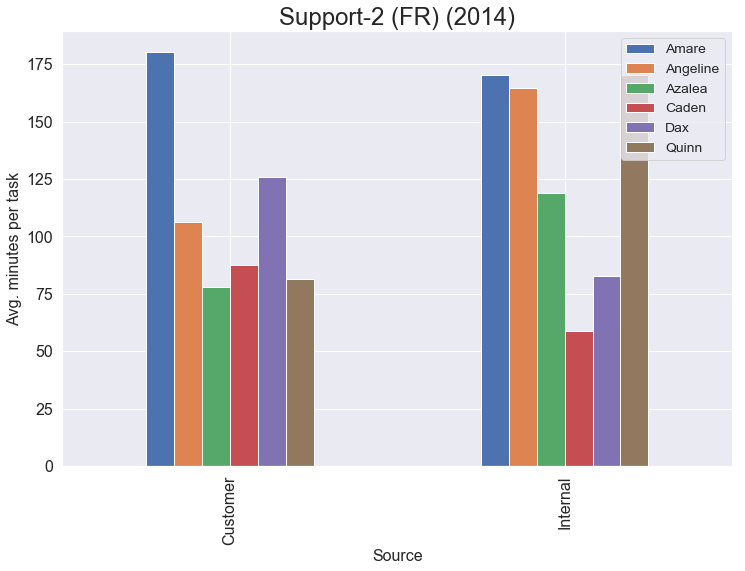

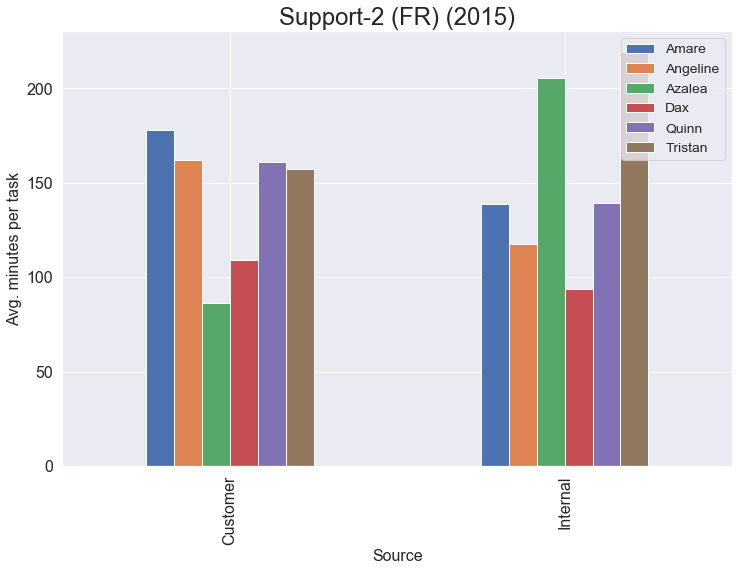

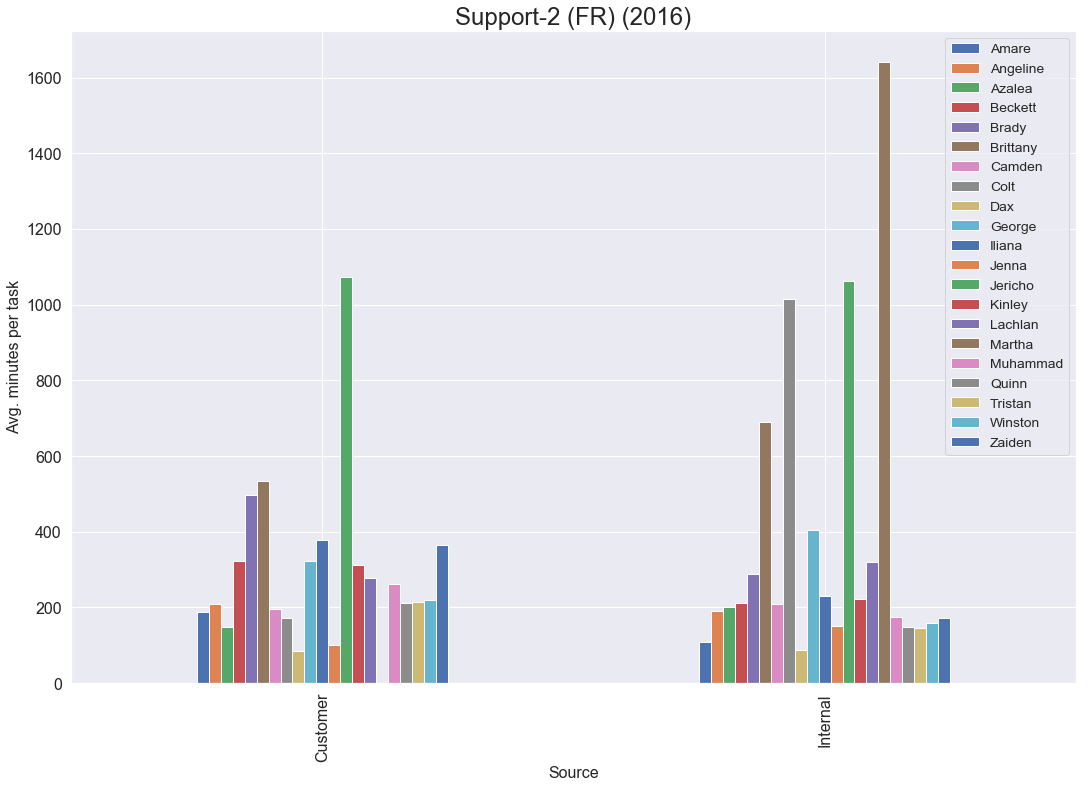

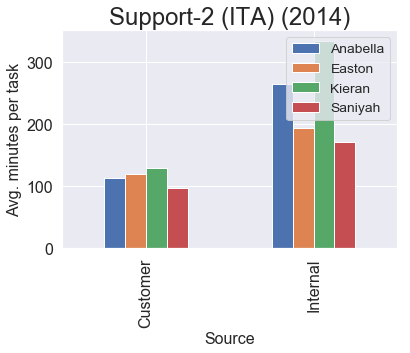

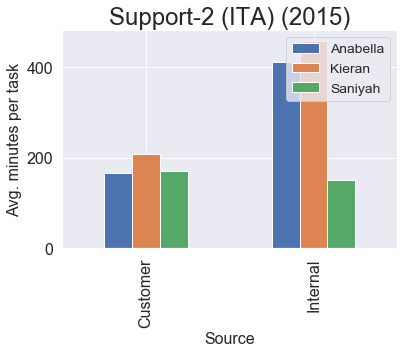

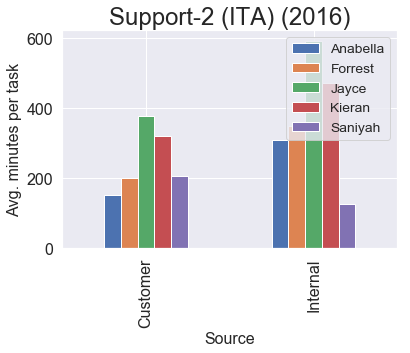

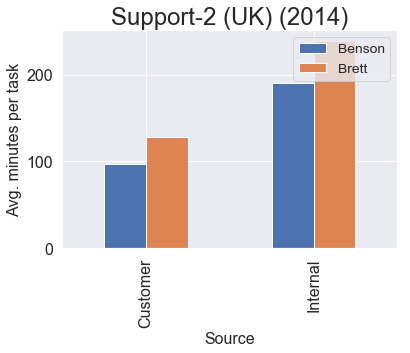

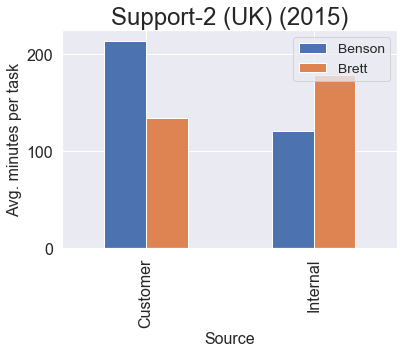

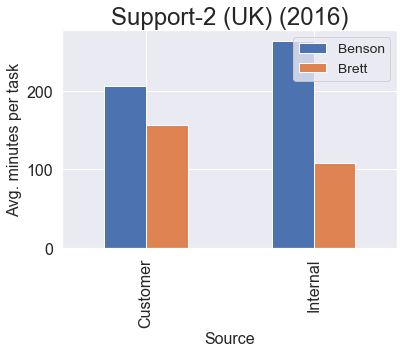

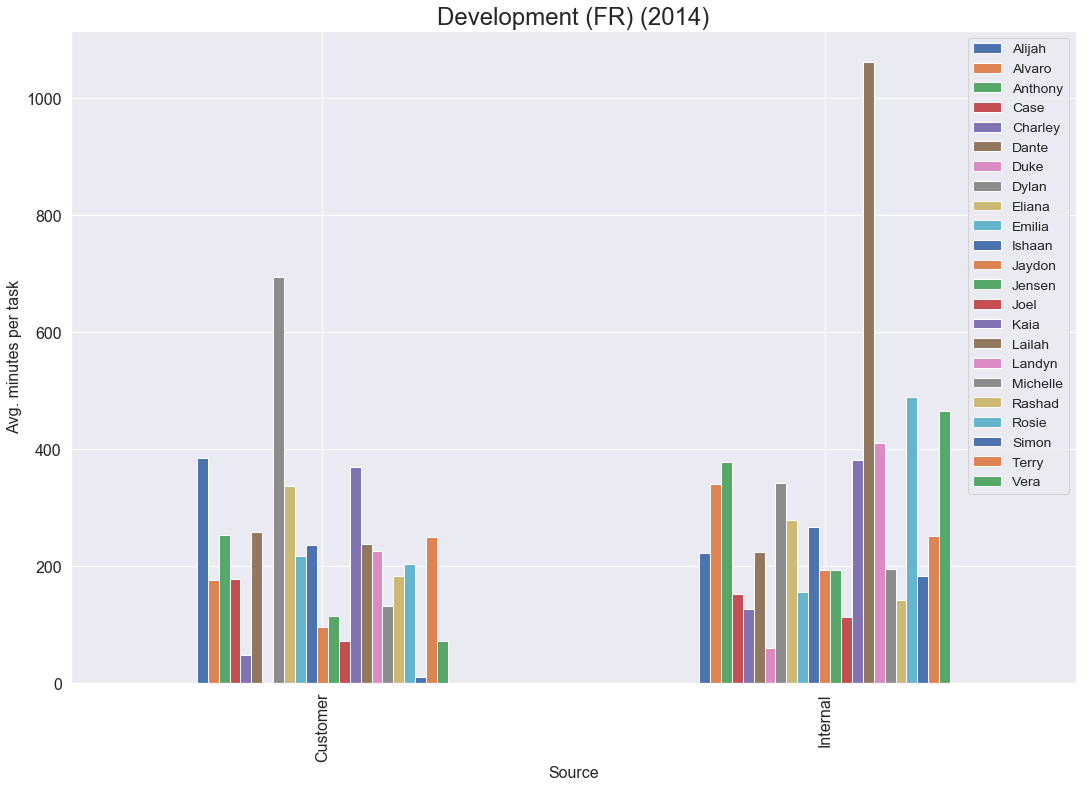

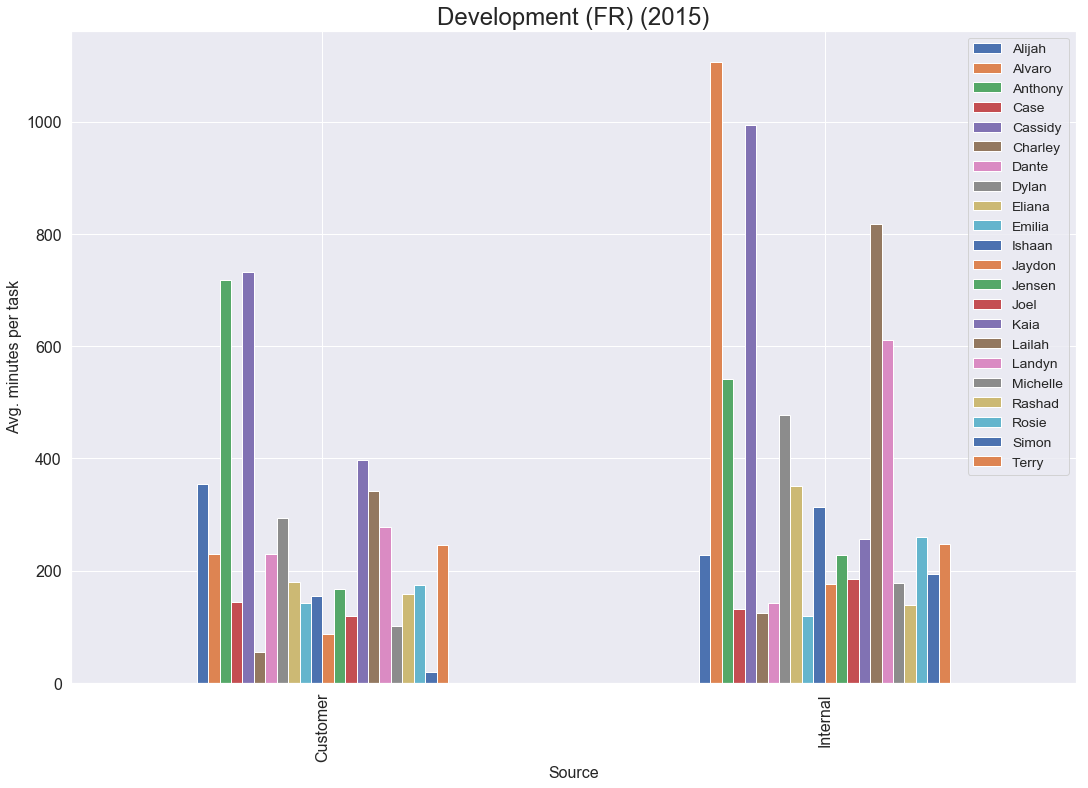

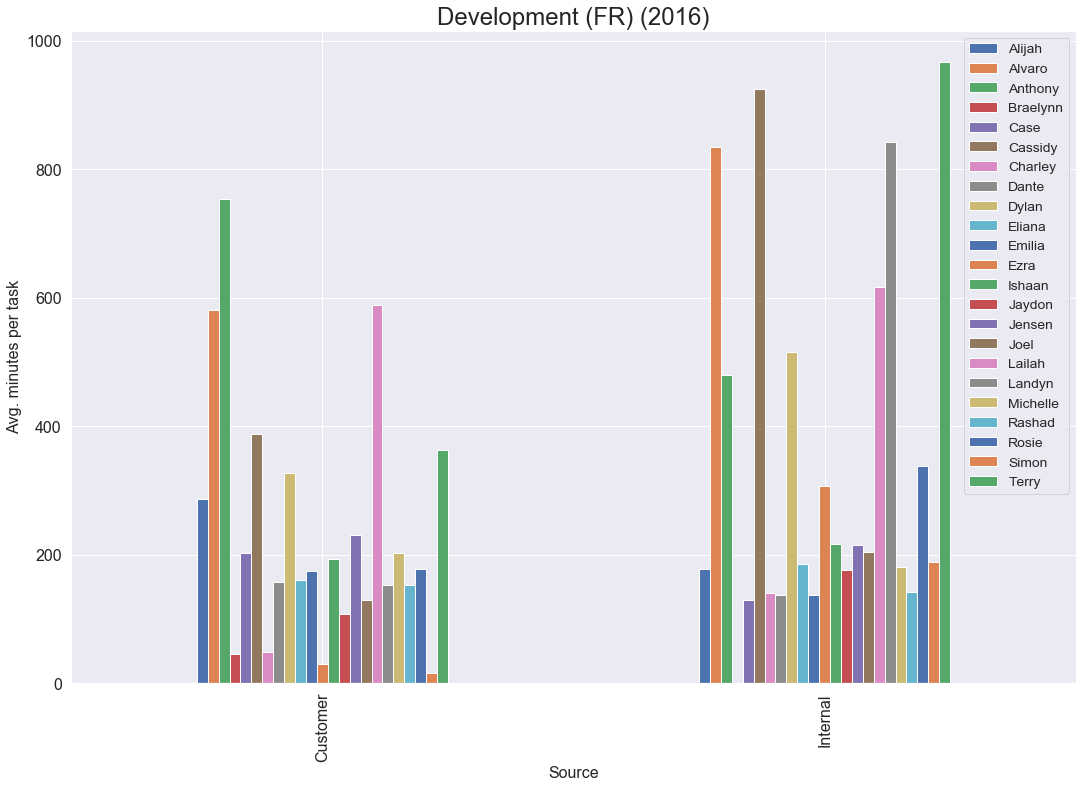

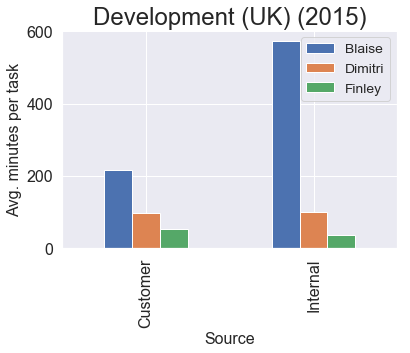

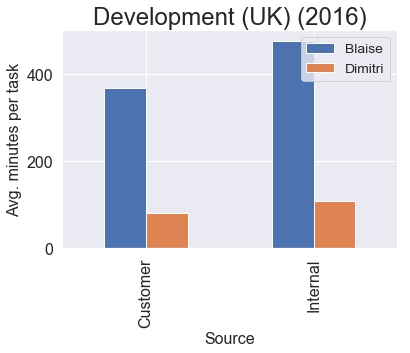

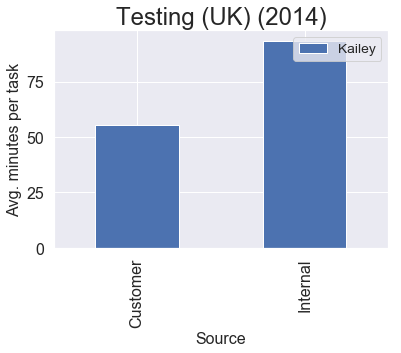

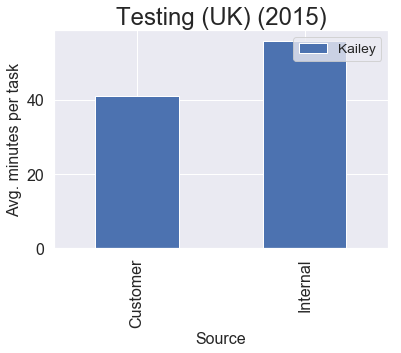

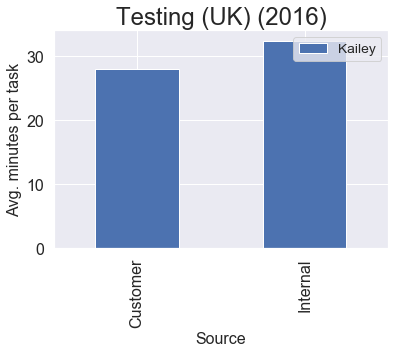

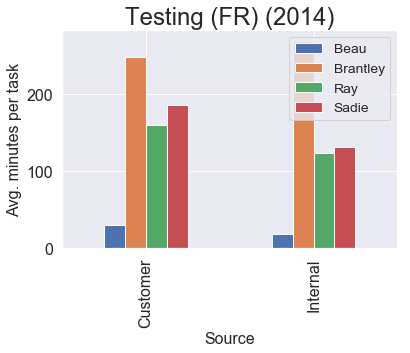

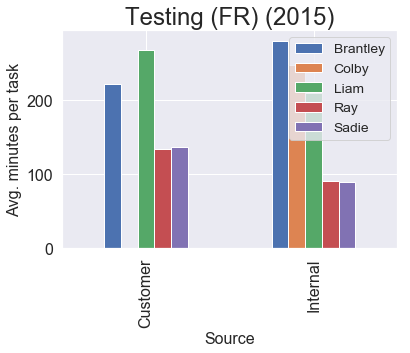

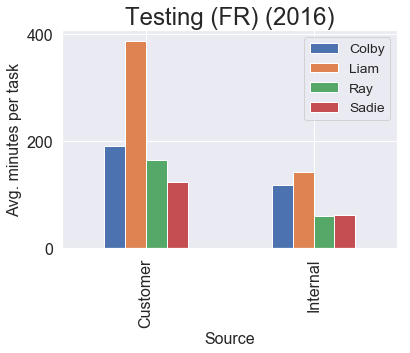

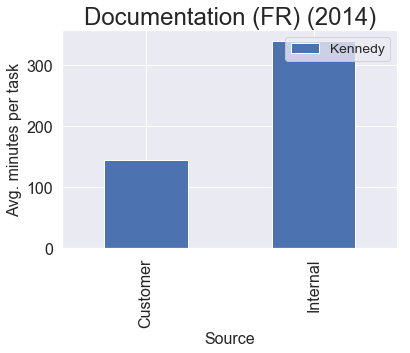

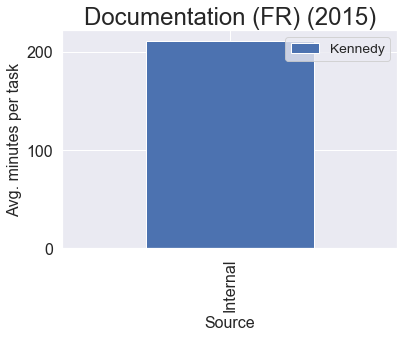

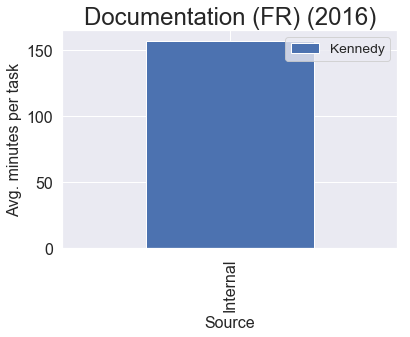

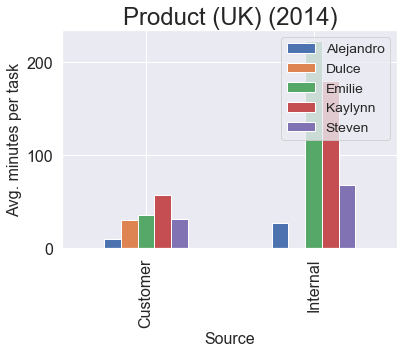

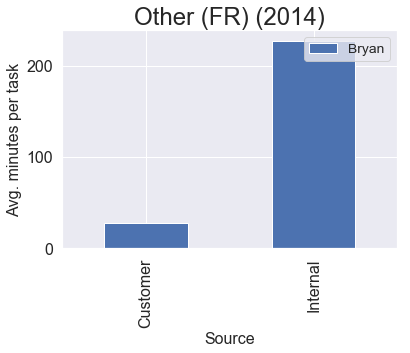

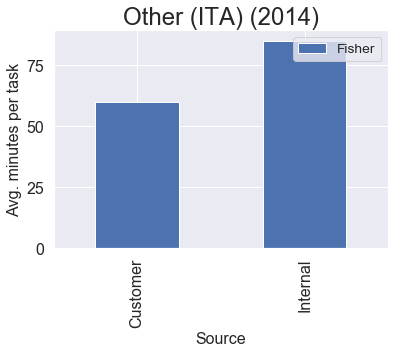

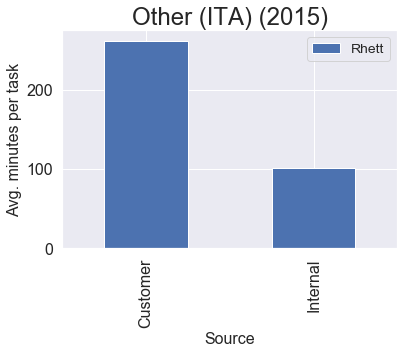

In [131]:
#Plotting employee efficiency by source (internal / customer), by department and year:
col="Source"
x_title='Source'

for i, el in enumerate(df_depts):
    df=el
    df=pd.DataFrame(df.groupby(['AssignedTo', col, 'year'], as_index=False)['WorkedMinutes'].mean())
    department=dept_names[i]
    efficiency_by_department(df, department, col, x_title)

We can see that there are many cases where an employee's efficiency, compared to the average efficiency of the department, in solving customer-related tasks is better than solving internal tasks, or vice versa. It might be useful for the management to take this information into account when deciding the work arrangements, so that tasks where a person does relatively better are assigned more often to that person. 

### Efficiency of individual employees by category of task, by department, country and year

C:\INSTALL\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


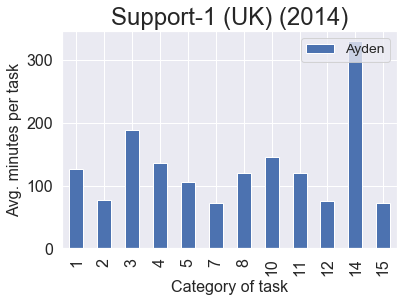

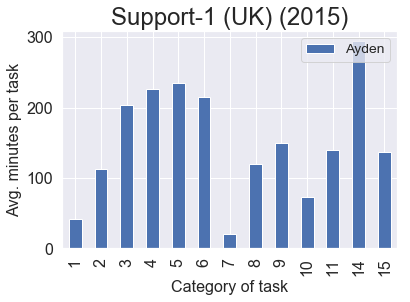

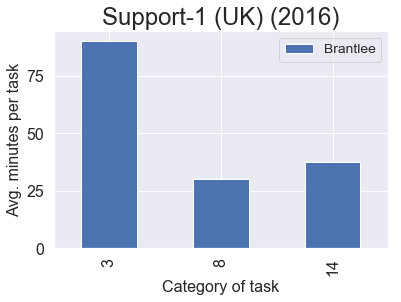

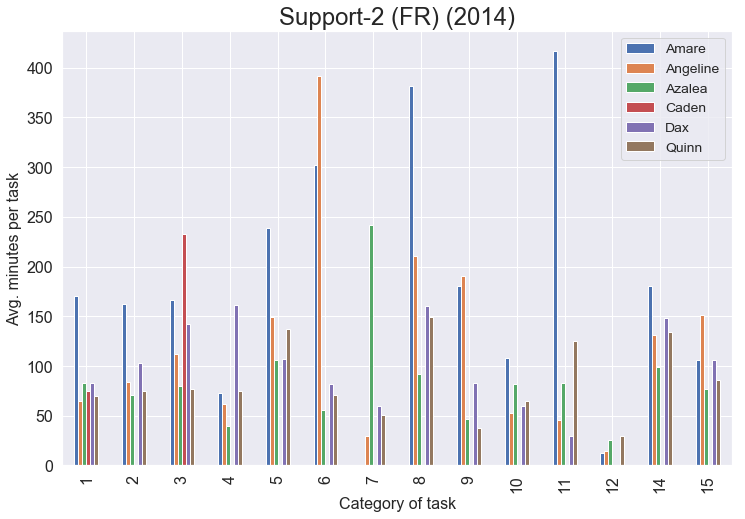

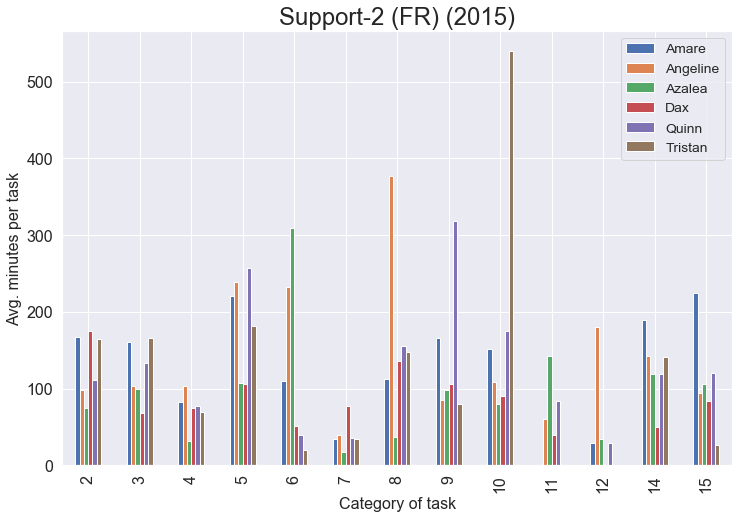

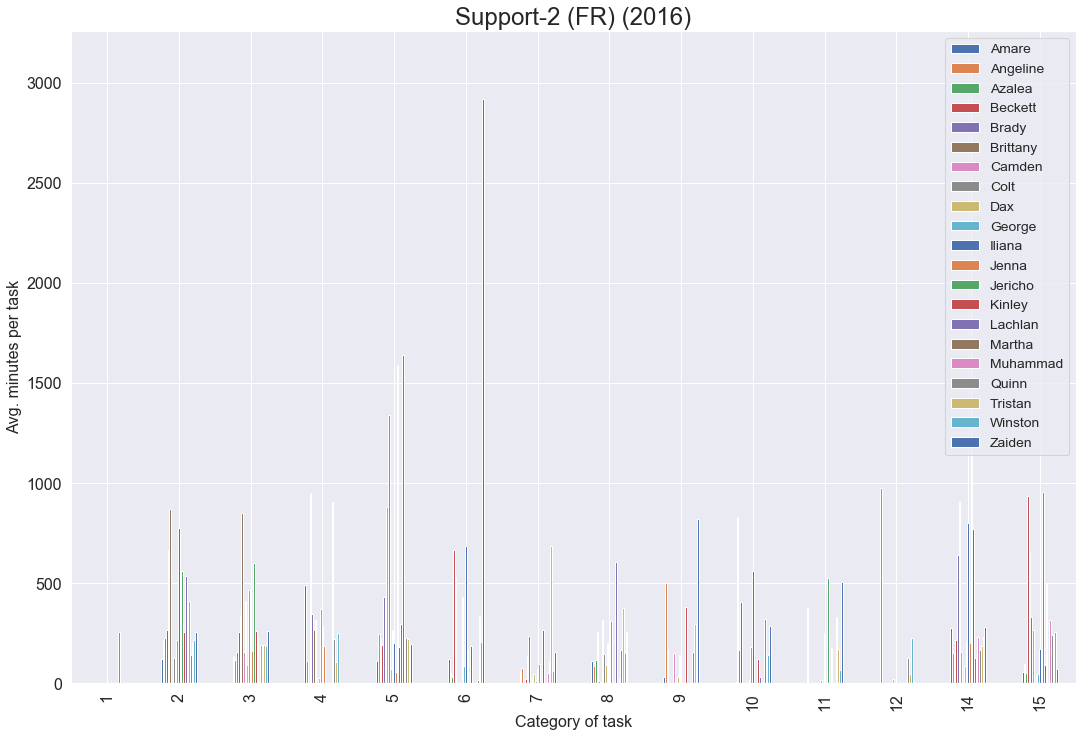

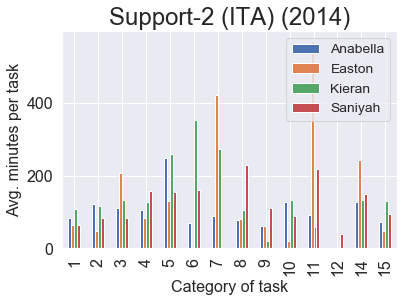

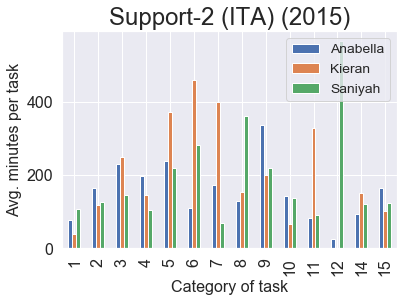

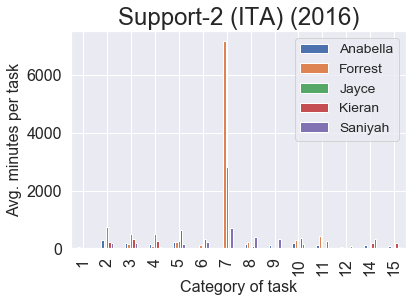

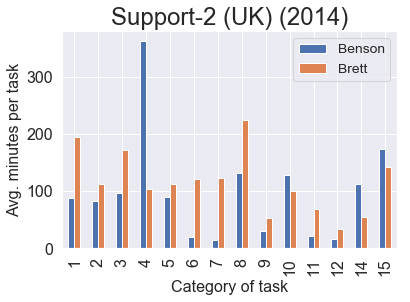

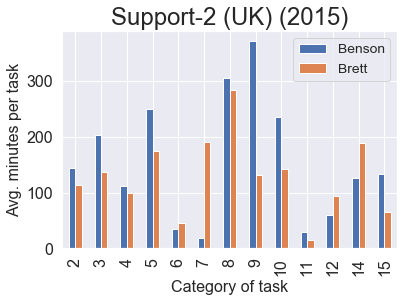

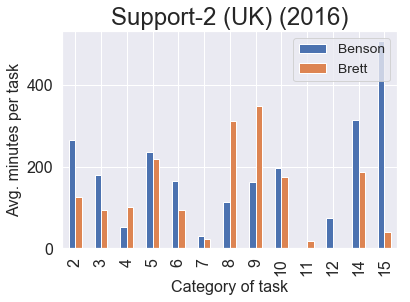

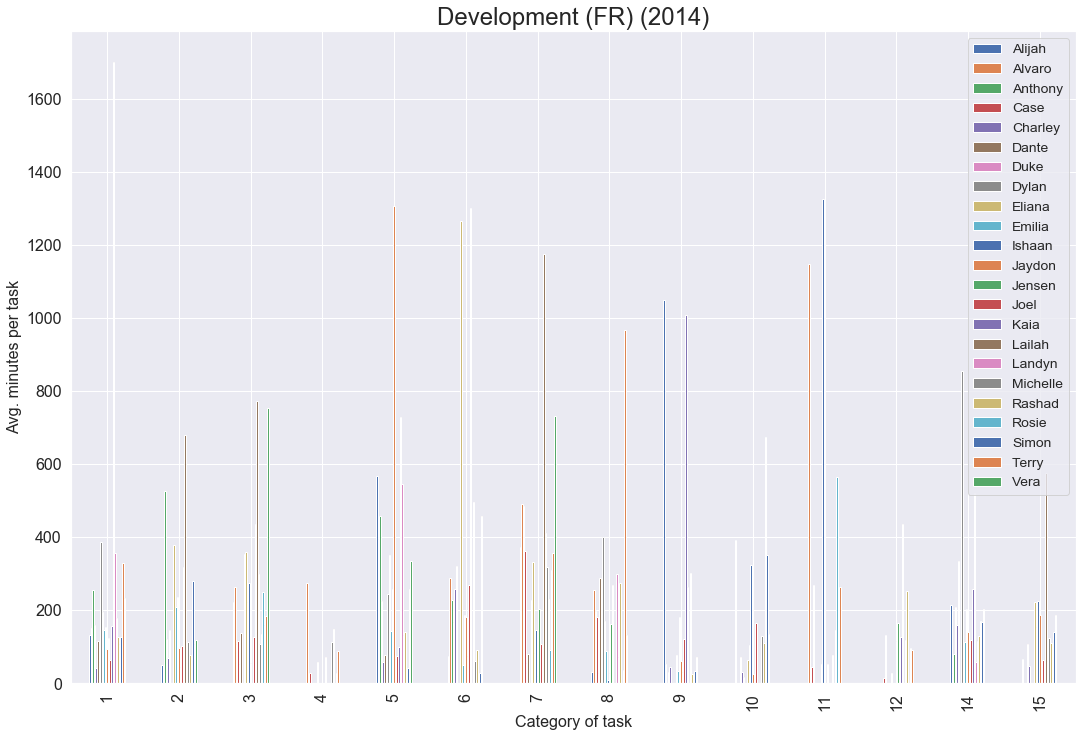

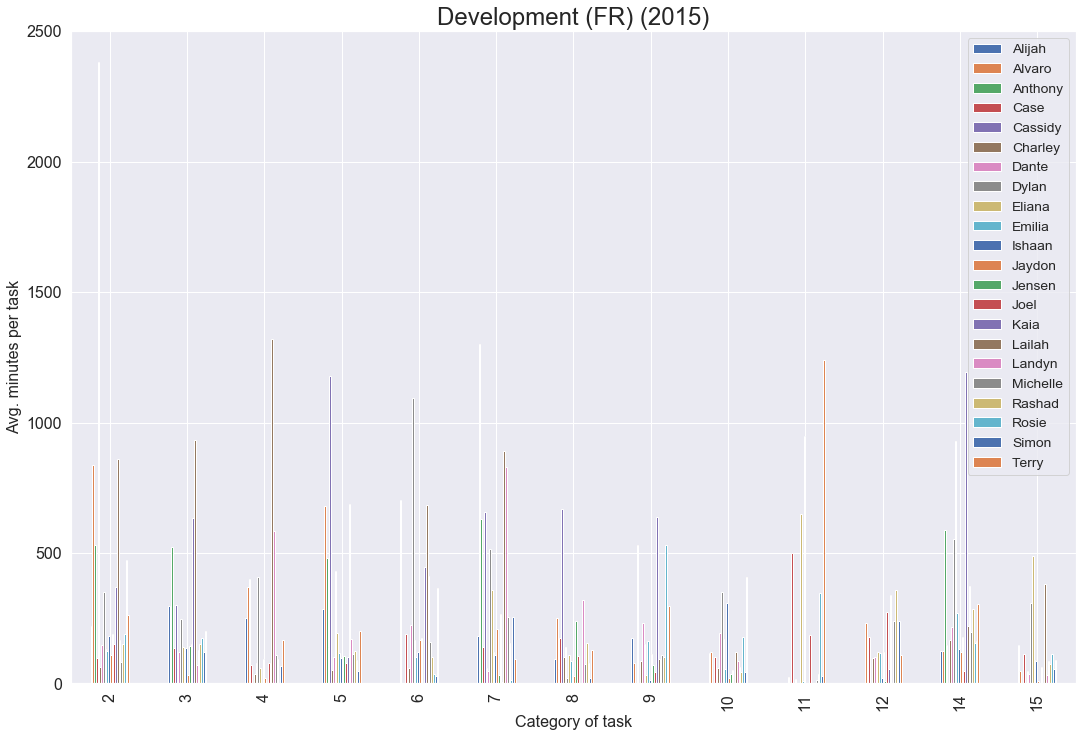

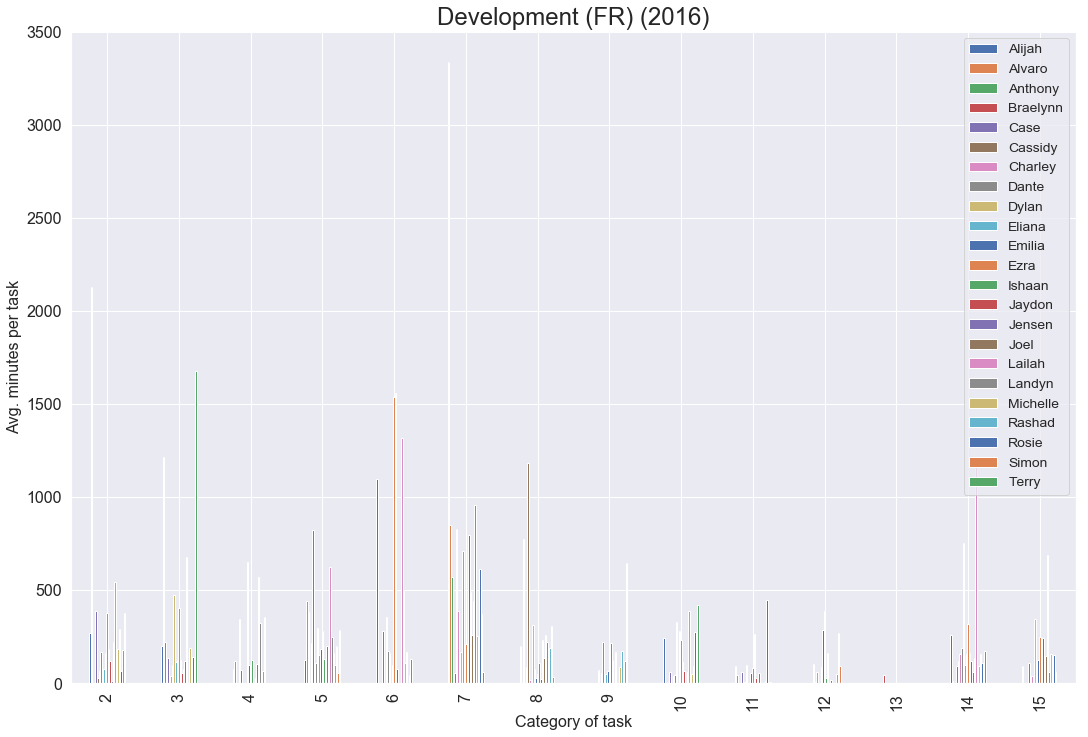

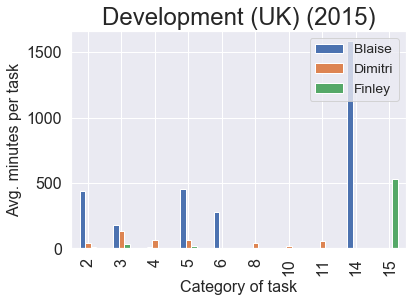

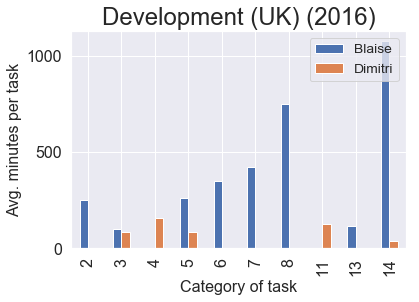

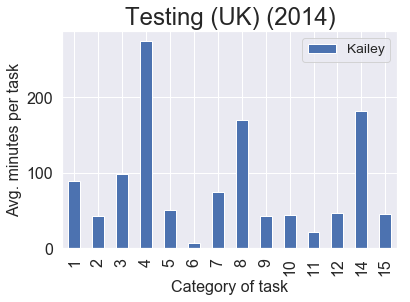

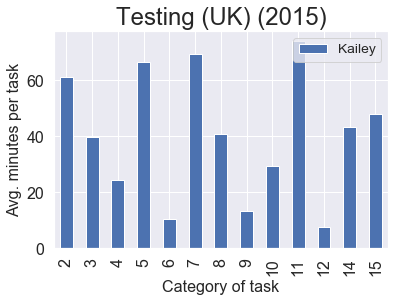

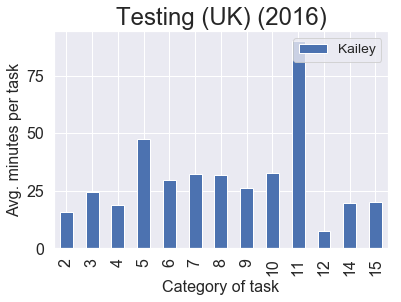

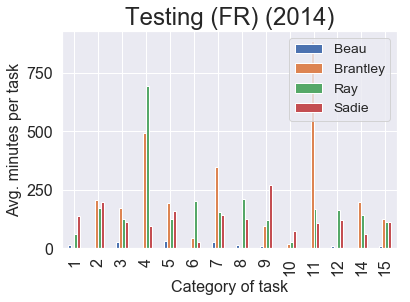

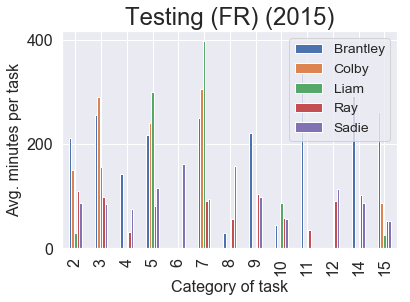

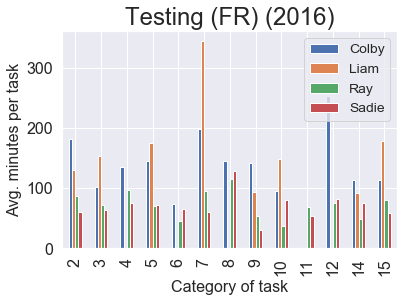

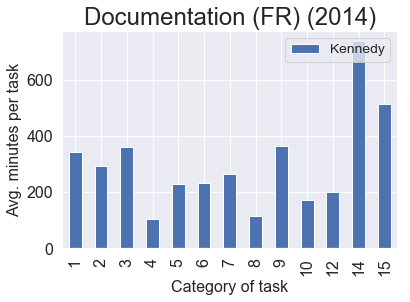

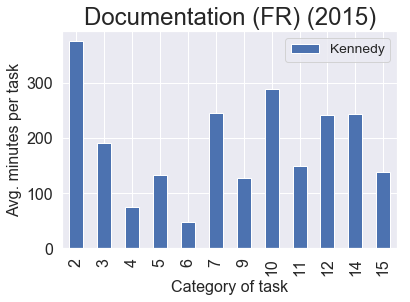

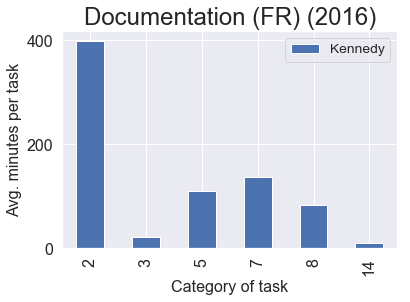

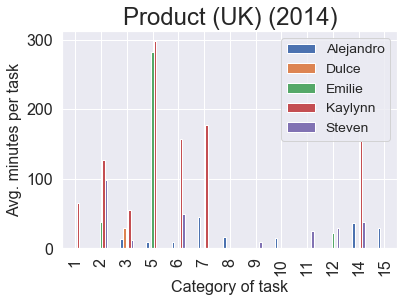

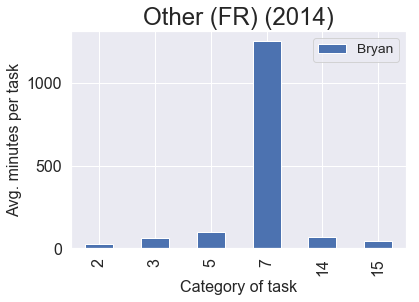

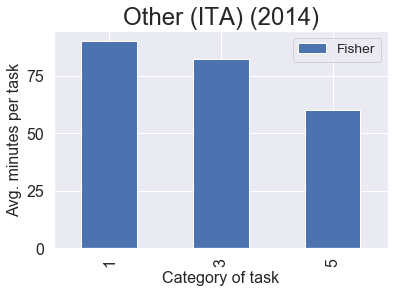

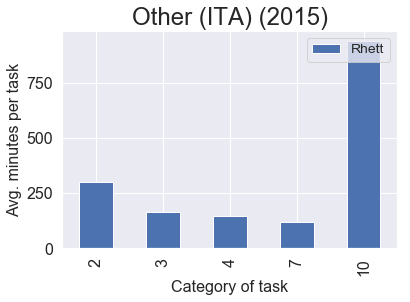

In [132]:
#Plotting employee efficiency by category of task, by department and year:
col="Category"
x_title='Category of task'

for i, el in enumerate(df_depts):
    df=el
    df=pd.DataFrame(df.groupby(['AssignedTo', col, 'year'], as_index=False)['WorkedMinutes'].mean())
    department=dept_names[i]
    efficiency_by_department(df, department, col, x_title)


We can see that there are many cases where an employee's efficiency, compared to the average efficiency of the department, in solving customer-related tasks is better than solving internal tasks, or vice versa. It might be useful for the management to take this information into account when deciding the work arrangements, so that tasks where a person does relatively better are assigned more often to that person. 

### Efficiency of individual employees by position, by department, country and year

C:\INSTALL\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


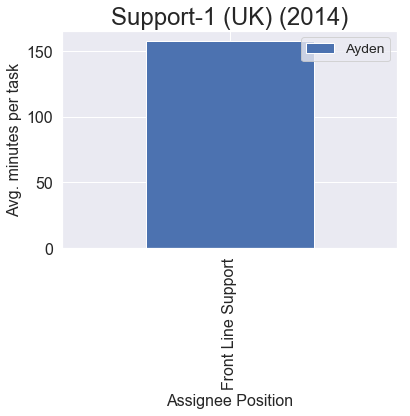

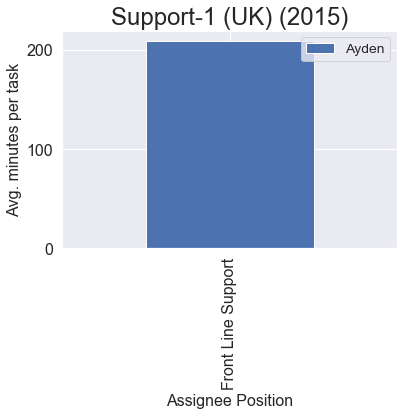

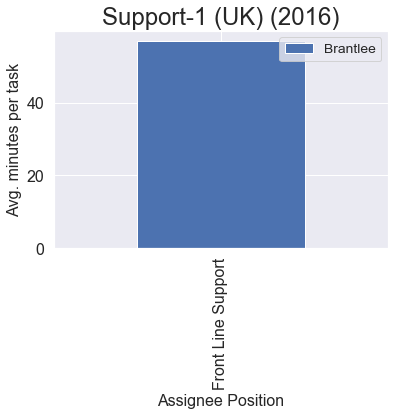

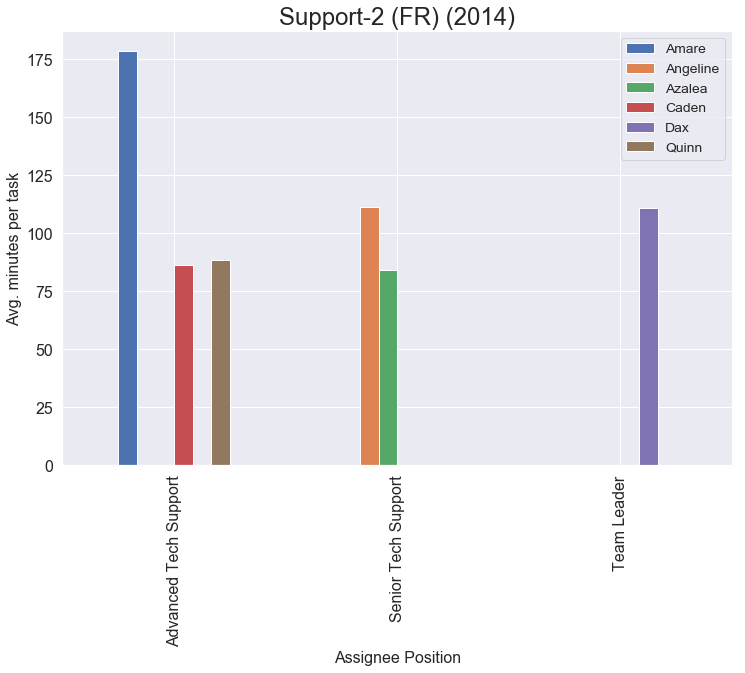

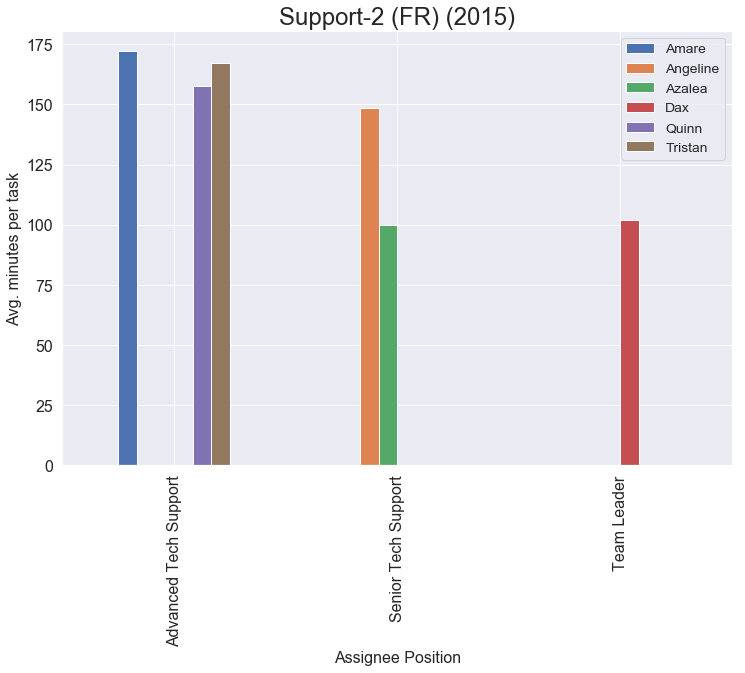

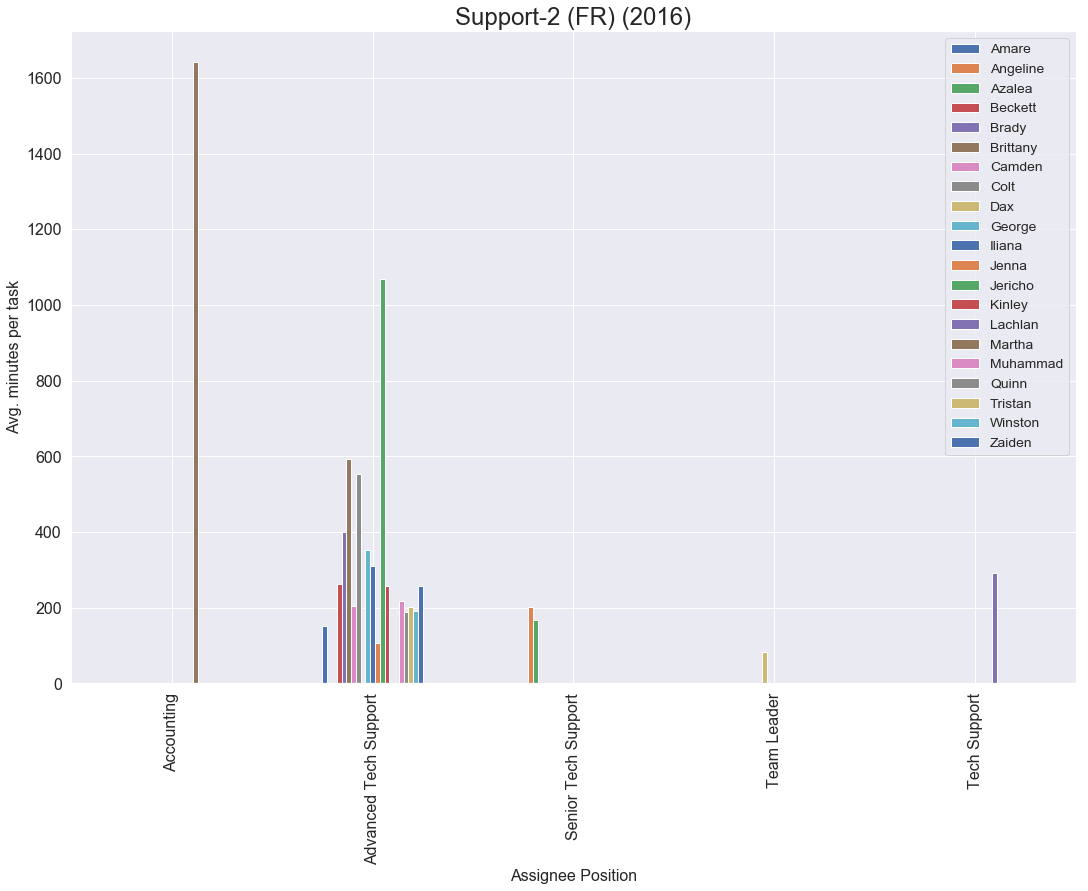

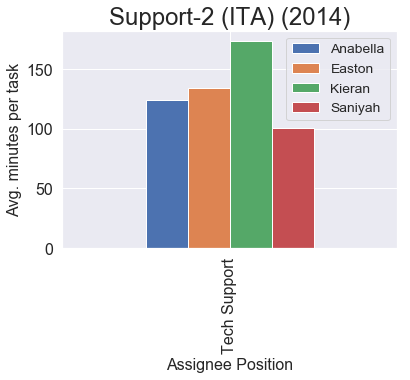

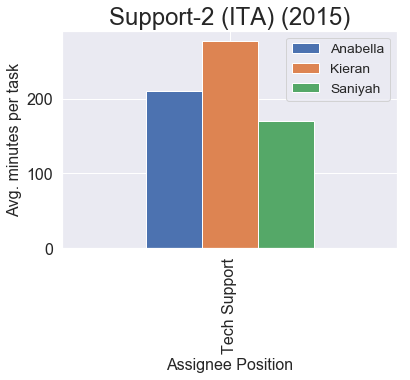

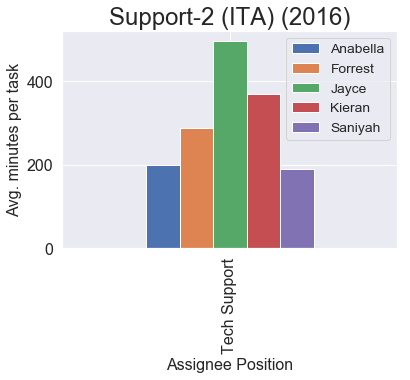

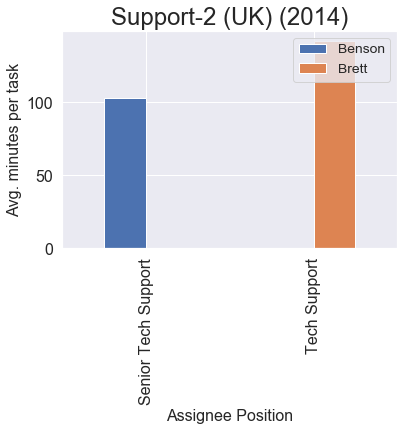

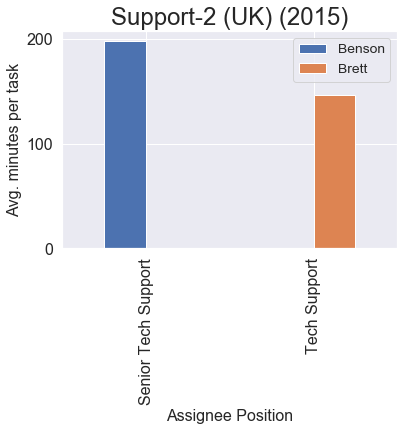

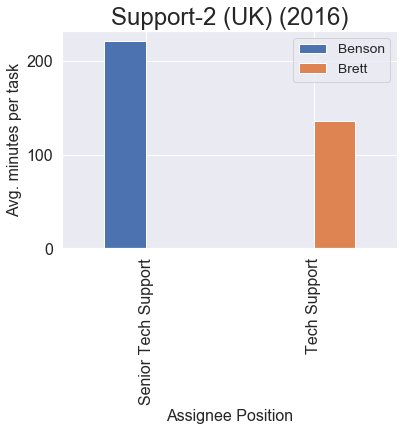

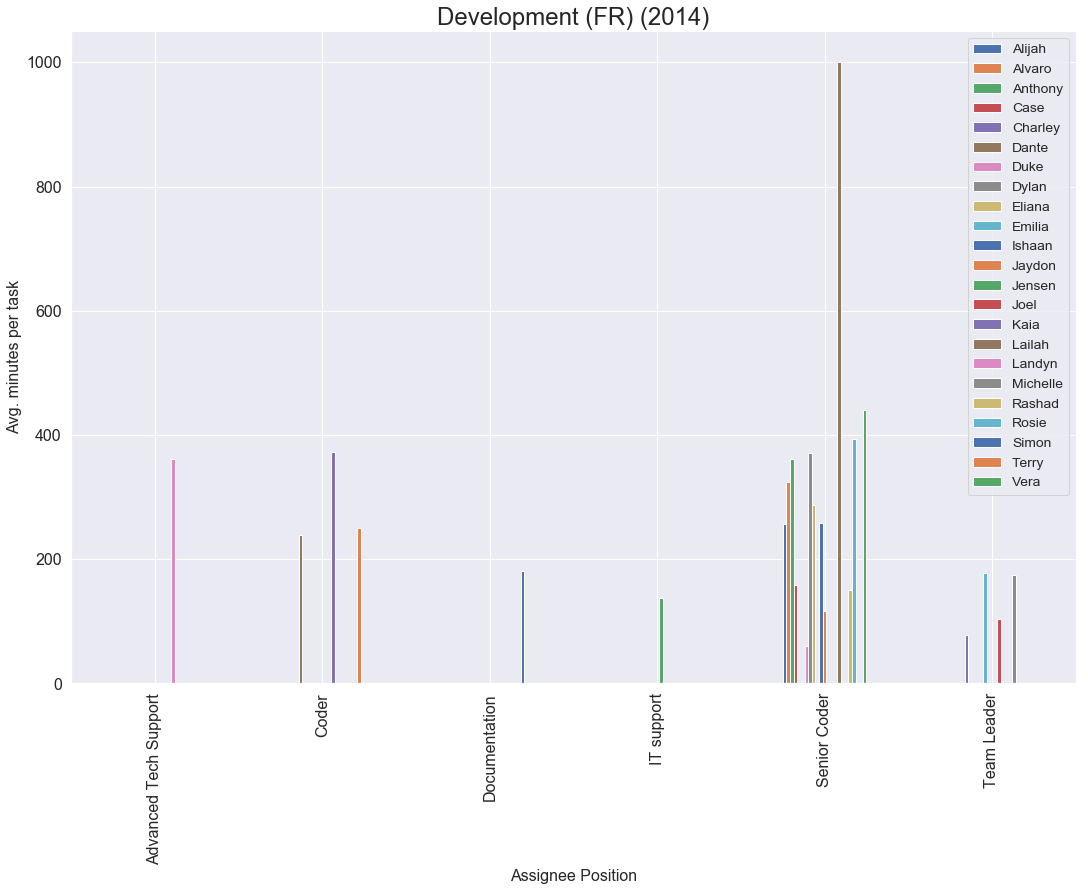

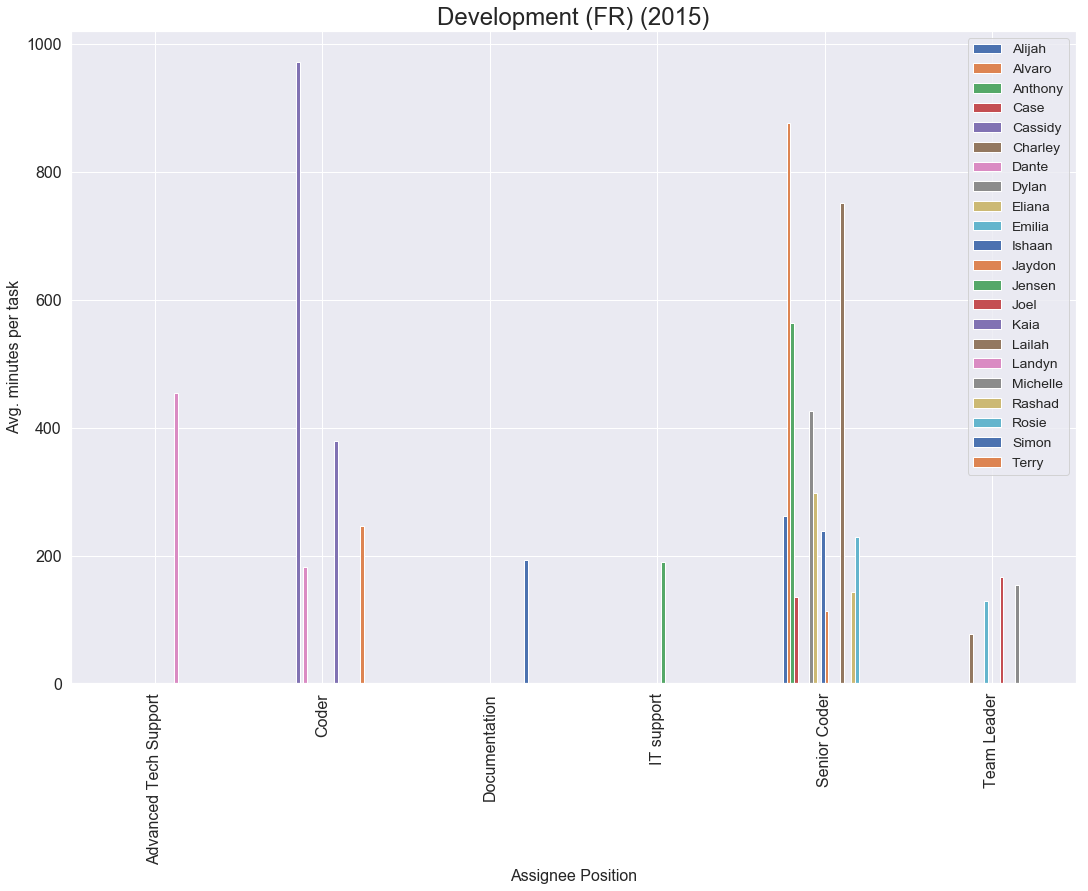

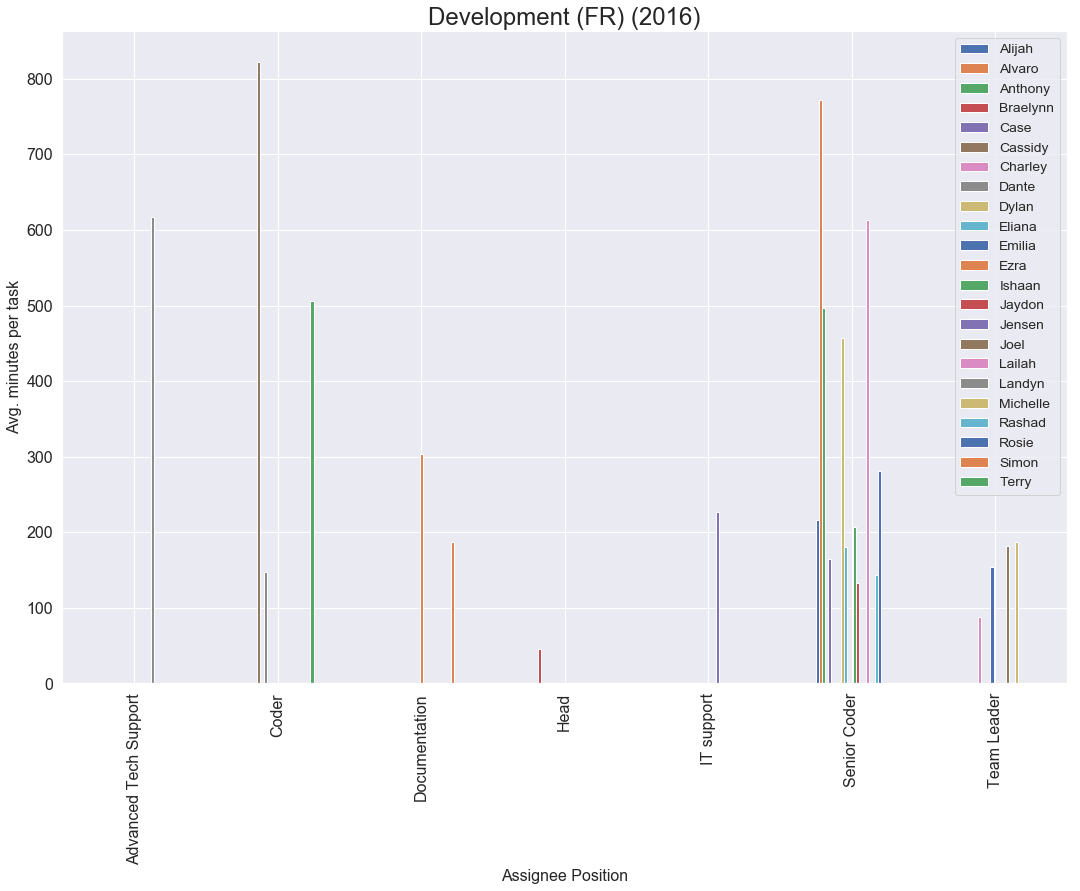

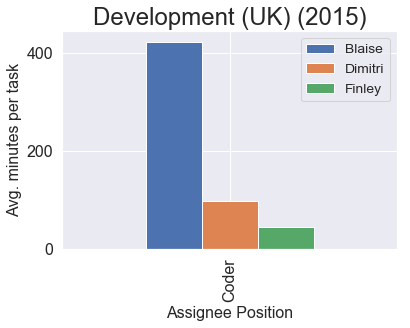

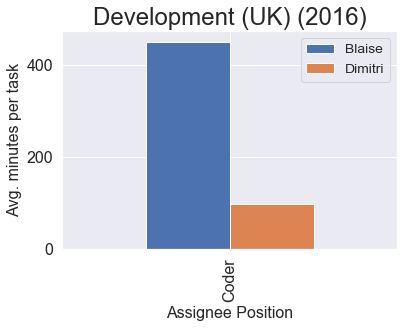

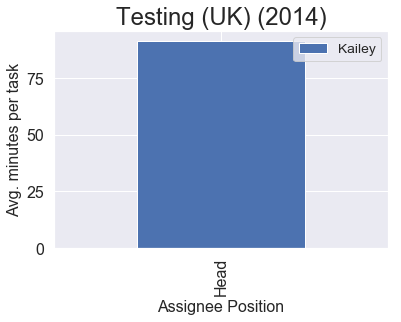

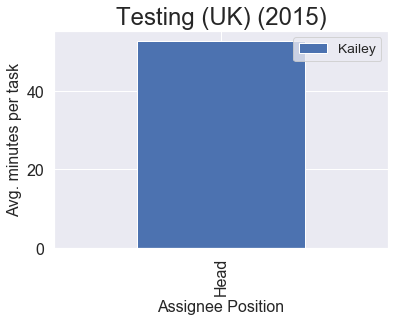

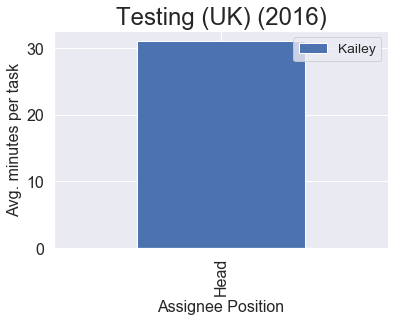

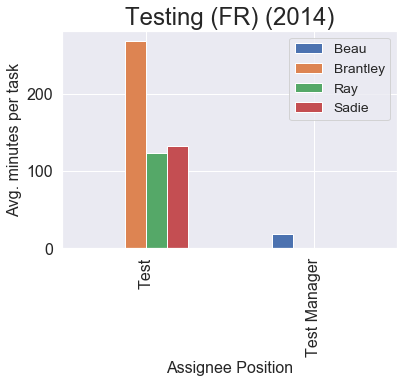

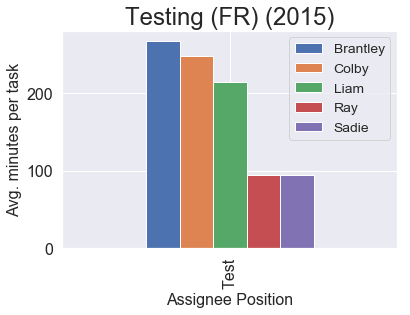

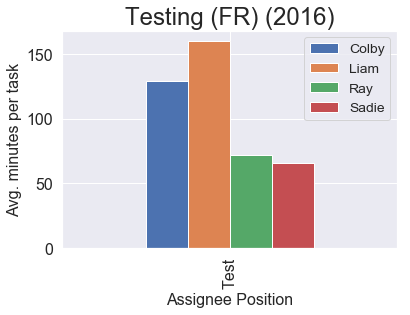

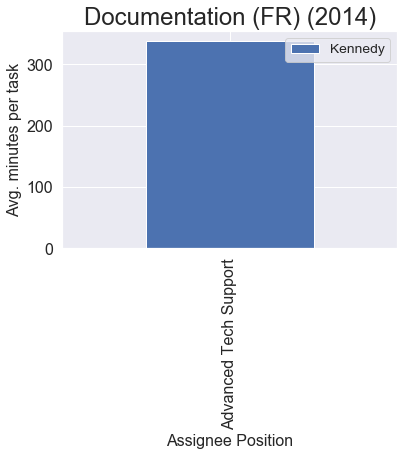

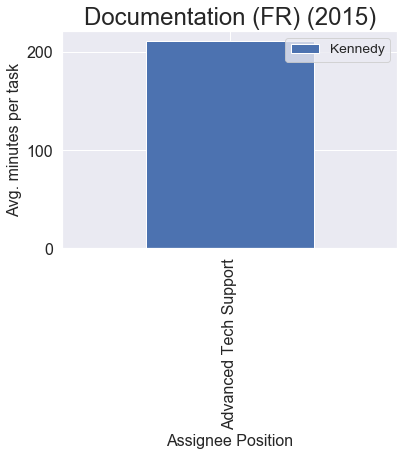

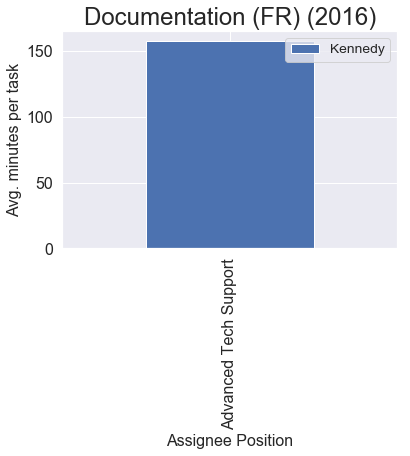

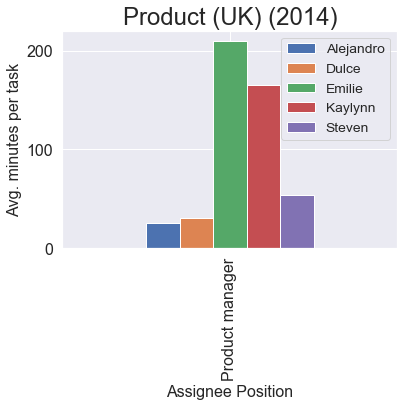

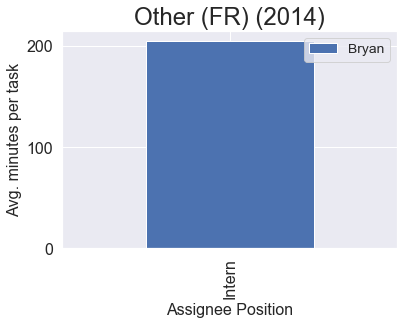

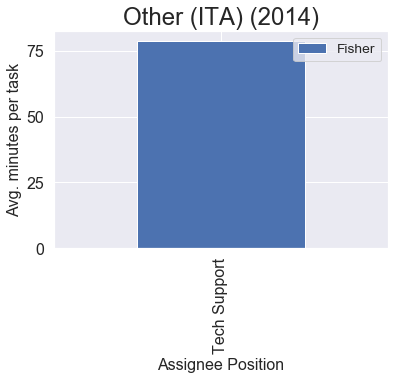

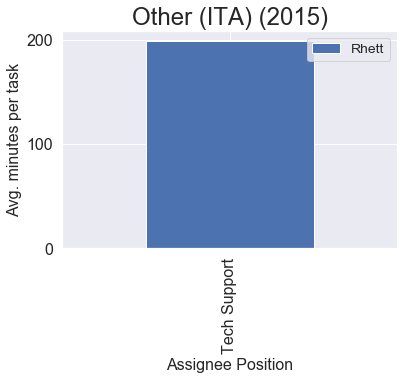

In [133]:
#Plotting employee efficiency by position, by department and year:
col="AssigneePosition"
x_title='Assignee Position'

for i, el in enumerate(df_depts):
    df=el
    df=pd.DataFrame(df.groupby(['AssignedTo', col, 'year'], as_index=False)['WorkedMinutes'].mean())
    department=dept_names[i]
    efficiency_by_department(df, department, col, x_title)


Average task completion times of team leaders are shorter than of the team members, which shows that they are not spending a long time on any single task.  We can see that in some cases  there are large differences in the efficiency of employees of the same position in the same department (for example between Senior Coders in the Development department, or Advanced Tech Support people in Support-2 department). It might be interesting fr the maangement to analyse the reasons for that, in order to decide if any measures should be taken to improve the efficiency of the employees whose efficiency is not so good. 